[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1tA6eTyCwGPQgkIV82Af4rLZM2N6WH5ZD)


## Importing Functions and Libraries

In [1]:
import sys
sys.path.append("/Users/praveenallam/Desktop/neural-network-regression")

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from functions import basic_info, shapiro_test, delivery_partners, order_protocol_value, store_category, market_map
from data_preprocessing import preprocessing_before_split, preprocessing_after_split, final_preprocessing
from category_encoders import TargetEncoder
from xgboost import XGBRegressor

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import R2Score
from tensorflow.keras.callbacks import TensorBoard

import optuna

import warnings 
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (9, 5)
color = ["#8ecae6", "#023047", "#219ebc", "#ffb703", "#fb8500", "#bc6c25"]

## Problem Statement

Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

The company works with a wide range of restaurants for delivering their items directly to the people.

The company has a number of delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers on the basis of what they are ordering, from where and also the delivery partners.

This dataset has the required data to train a regression model that will do the delivery time estimation, based on all those features

This dataset has the required data to train a regression model that will do the delivery time estimation, based on all those features

> Data Dictionary

Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below.

1. *market_id* : integer id for the market where the restaurant lies <br>
2. *created_at* : the timestamp at which the order was placed <br>
3. *actual_delivery_time* : the timestamp when the order was delivered <br>
4. *store_primary_category* : category for the restaurant <br>
5. *order_protocol* : integer code value for order protocol(how the order was placed ie: through porter, call to restaurant, pre booked, third part etc) <br>
6. *total_items subtotal* : final price of the order <br>
7. *num_distinct_items* : the number of distinct items in the order <br>
8. *min_item_price* : price of the cheapest item in the order <br>
9. *max_item_price* : price of the costliest item in order <br>
10. *total_onshift_partners* : number of delivery partners on duty at the time order was placed <br>
11. *total_busy_partners* : number of delivery partners attending to other tasks <br>
12. *total_outstanding_orders* : total number of orders to be fulfilled at the moment <br>

## Reading data and basic info, preprocessing

In [3]:
df = pd.read_csv("../datasets/dataset.csv")
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [4]:
basic_info(df)

shape of the date : 
	rows = 197428, columns = 14

missing values: 
	count = 55535


,feature,missing_val_count,missing_val_percentage
11,total_onshift_partners,16262,8.24
12,total_busy_partners,16262,8.24
13,total_outstanding_orders,16262,8.24
4,store_primary_category,4760,2.41
5,order_protocol,995,0.50
0,market_id,987,0.50
2,actual_delivery_time,7,0.00
1,created_at,0,0.00
3,store_id,0,0.00
6,total_items,0,0.00


duplicated records: 
	count = 0

Unique Values : 


,feature,nunique_vals
0,market_id,6
1,created_at,180985
2,actual_delivery_time,178110
3,store_id,6743
4,store_primary_category,74
5,order_protocol,7
6,total_items,57
7,subtotal,8368
8,num_distinct_items,20
9,min_item_price,2312


,fetaure,data type
0,market_id,float64
1,created_at,object
2,actual_delivery_time,object
3,store_id,object
4,store_primary_category,object
5,order_protocol,float64
6,total_items,int64
7,subtotal,int64
8,num_distinct_items,int64
9,min_item_price,int64


In [5]:
df.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
market_id,196441.0,NaN,NaN,NaN,2.978706,1.524867,1.0,2.0,3.0,4.0,6.0
created_at,197428,180985,2015-02-11 19:50:43,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
actual_delivery_time,197421,178110,2015-02-11 20:40:45,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_id,197428,6743,d43ab110ab2489d6b9b2caa394bf920f,937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_primary_category,192668,74,american,19399,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_protocol,196433.0,NaN,NaN,NaN,2.882352,1.503771,1.0,1.0,3.0,4.0,7.0
total_items,197428.0,NaN,NaN,NaN,3.196391,2.666546,1.0,2.0,3.0,4.0,411.0
subtotal,197428.0,NaN,NaN,NaN,2682.331402,1823.093688,0.0,1400.0,2200.0,3395.0,27100.0
num_distinct_items,197428.0,NaN,NaN,NaN,2.670791,1.630255,1.0,1.0,2.0,3.0,20.0
min_item_price,197428.0,NaN,NaN,NaN,686.21847,522.038648,-86.0,299.0,595.0,949.0,14700.0


- there are no duplicated records
- there are some missing values, which we will impute later
- for ***num_distinct_items***, ***subtotal***, ***total_items***, ***max_item_price***, there is a huge gap between 75% and max value 
- there are some negative values and right skew in ***min_item_price*** 
- ***total_onshift_partners***, ***total_busy_partners***, ***total_outstanding_orders*** they might have some little skew but they got negative values (which is unexpected)

## Data Preprocessing

In [6]:
df = preprocessing_before_split(df)

remaining cols with missing values = Index(['total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders'],
      dtype='object')


In [7]:
df_copy = df.copy()
df_copy.shape

(197421, 22)

In [8]:
numerical_cols = [col for col in df.columns if df_copy[col].dtype != "O" and df_copy[col].dtype != "category" and df_copy[col].dtype != "<M8[ns]"]
neg_valued_cols = df_copy[numerical_cols].columns[(df_copy[numerical_cols] < 0).any(axis = 0)].tolist()
df_neg = df_copy[(df_copy[neg_valued_cols] < 0).any(axis=1)]

In [9]:
df_copy.drop(df_copy[df_copy.created_at_month == "October"].index, axis = 0, inplace = True)
df_copy.drop(df_neg.index, axis = 0 , inplace = True)
df_copy.shape

(197326, 22)

In [10]:
X = df_copy.drop("delivery_time", axis = 1).copy()
y = df_copy.delivery_time.copy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print(f"the shape of train data : ")
print(f"   X_train = {X_train.shape}\n   y_train = {y_train.shape}")
print("--" * 20)
print(f"the shape of test data : ")
print(f"   X_test = {X_test.shape}\n   y_test = {y_test.shape}")
print("--" * 60)

the shape of train data : 
   X_train = (157860, 21)
   y_train = (157860,)
----------------------------------------
the shape of test data : 
   X_test = (39466, 21)
   y_test = (39466,)
------------------------------------------------------------------------------------------------------------------------


In [12]:
delivery_partners_grps = X_train.groupby(by = ["created_at_weekday", "created_at_hour"])[["total_onshift_partners", "total_busy_partners", "total_outstanding_orders"]].apply("mean").round().reset_index()
mean_total_onshift_partners = X_train.total_onshift_partners.mean()
mean_total_busy_partners = X_train.total_busy_partners.mean()
mean_total_outstanding_orders = X_train.total_outstanding_orders.mean()

delivery_partners_avgs = [mean_total_onshift_partners, mean_total_busy_partners, mean_total_outstanding_orders]

X_train = preprocessing_after_split(X_train, delivery_partners_avgs = delivery_partners_avgs, delivery_partners_grps = delivery_partners_grps)
X_test = preprocessing_after_split(X_test, delivery_partners_avgs = delivery_partners_avgs, delivery_partners_grps = delivery_partners_grps)

In [13]:
train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
test = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True)], axis = 1)

In [14]:
outlier_cols = ["total_items", "subtotal", "num_distinct_items", "min_item_price", "max_item_price", "total_onshift_partners", "total_busy_partners", "total_outstanding_orders", "delivery_time"]
encoding_cols = [col for col in X_train.columns if X_train[col].nunique() <= 30 or X_train[col].dtype == "O"]

In [15]:
features, X_train_sca, X_test_sca, y_train, y_test = final_preprocessing(train, test, outlier_cols, encoding_cols)

## EDA

In [23]:
skew_info = df[numerical_cols].skew().round(2)

### Univariate Analysis

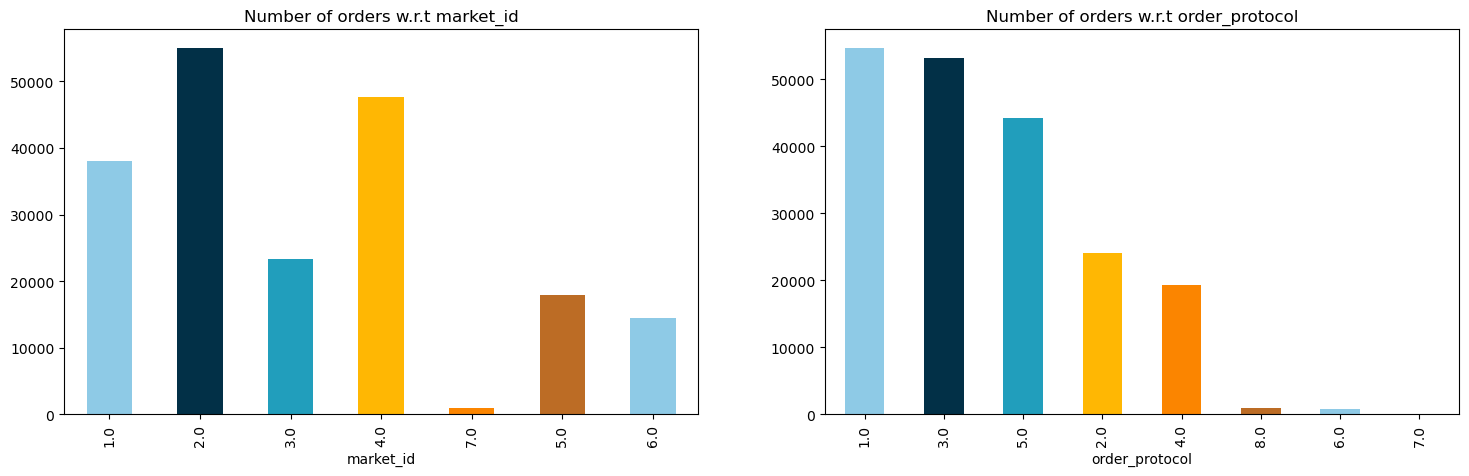

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
df.market_id.value_counts(sort = False, dropna = False).plot(kind = "bar", color = color, ax = ax[0])
ax[0].set_title("Number of orders w.r.t market_id")
df["order_protocol"].value_counts(dropna = False).plot(kind = "bar", color = color, ax = ax[1])
ax[1].set_title("Number of orders w.r.t order_protocol")
plt.show()

feature num_distinct_items - 
Sample does not look Gaussian (reject H0)
skew = 1.59 

feature total_items - 
Sample does not look Gaussian (reject H0)
skew = 21.41


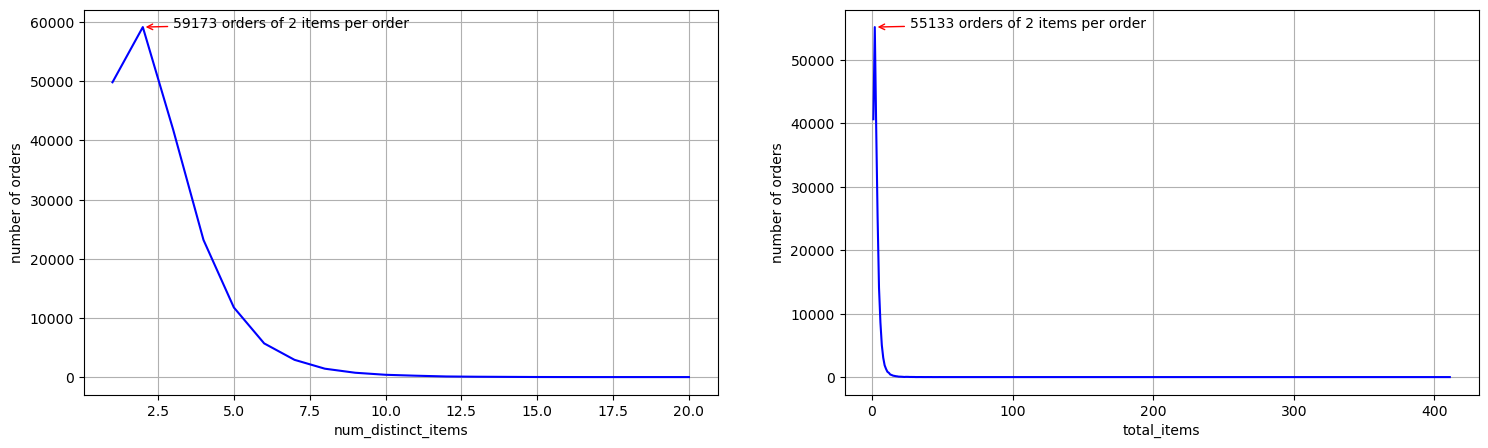

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

print(f"feature num_distinct_items - ")
shapiro_test(df.num_distinct_items)
print(f"skew = {skew_info.loc['num_distinct_items']} \n")

print(f"feature total_items - ")
shapiro_test(df.total_items)
print(f"skew = {skew_info.loc['total_items']}")


df["num_distinct_items"].value_counts().sort_index().plot(kind = "line", grid = True, ylabel = "number of orders", color = "blue", ax = ax[0])
# Finding the maximum value and its corresponding x-coordinate
max_value = df["num_distinct_items"].value_counts().max()
max_index = df["num_distinct_items"].value_counts().idxmax()

# Annotating the maximum point
ax[0].annotate(f'{max_value} orders of {max_index} items per order', xy=(max_index, max_value), xytext=(max_index+1, max_value - 100), arrowprops=dict(arrowstyle='->', color = "red"))

df["total_items"].value_counts().sort_index().plot(kind = "line", grid = True, ylabel = "number of orders", color = "blue", ax = ax[1])
# Finding the maximum value and its corresponding x-coordinate
max_value = df["total_items"].value_counts().max()
max_index = df["total_items"].value_counts().idxmax()

# Annotating the maximum point
ax[1].annotate(f'{max_value} orders of {max_index} items per order', xy=(max_index, max_value), xytext=(max_index+25, max_value - 100), arrowprops=dict(arrowstyle='->', color = "red"))

plt.show()

> we can see that there is a right skew in the above features, but total_items got more skew 

feature created_at_hour - 
Sample does not look Gaussian (reject H0)
skew = 0.63 



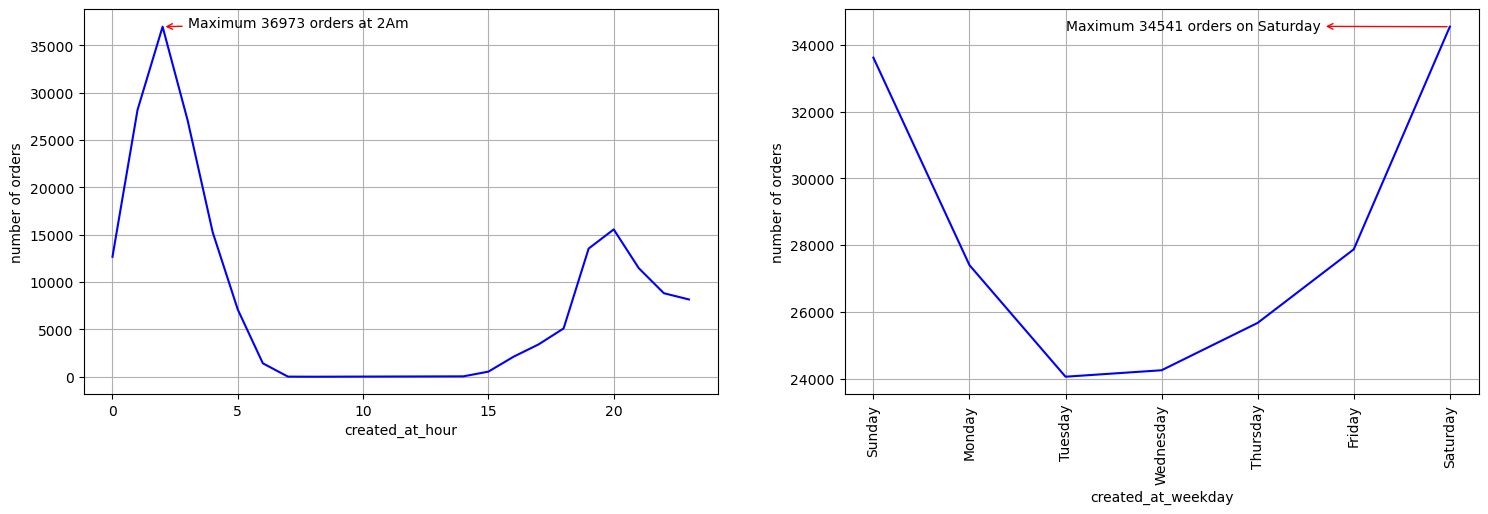

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

print(f"feature created_at_hour - ")
shapiro_test(df.created_at_hour)
print(f"skew = {skew_info.loc['created_at_hour']} \n")

df["created_at_hour"].value_counts().sort_index().plot(kind = "line", grid = True, ylabel = "number of orders", color = "blue", ax = ax[0])
max_value = df["created_at_hour"].value_counts().max()
max_index = df["created_at_hour"].value_counts().idxmax()

ax[0].annotate(f'Maximum {max_value} orders at {max_index}Am', xy=(max_index, max_value), xytext=(max_index+1, max_value - 100), arrowprops=dict(arrowstyle='->', color = "red"))

day_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
df["created_at_weekday"].value_counts().reindex(day_order).plot(kind="line", grid=True, ylabel="number of orders", color="blue", ax = ax[1])
plt.xticks(rotation=90)

max_value = df["created_at_weekday"].value_counts().max()
max_index = df["created_at_weekday"].value_counts().idxmax()

ax[1].annotate(f'Maximum {max_value} orders on {max_index}', xy=(day_order.index(max_index), max_value), xytext=(day_order.index(max_index) - 4, max_value - 100), arrowprops=dict(arrowstyle='<-', color="red"))
plt.show()

In [26]:
df["created_at_month"].value_counts().reset_index()

,created_at_month,count
0,February,128938
1,January,68482
2,October,1


> the data contains the the orders that are created in January, February and a single order created in october

- may be the created_at_month be a good feature here, as it does not contain every month
- and order placed in october might be an outler, let's check that later

feature actual_delivery_hour - 
Sample does not look Gaussian (reject H0)
skew = 0.75 

average time for delivery = 48.47


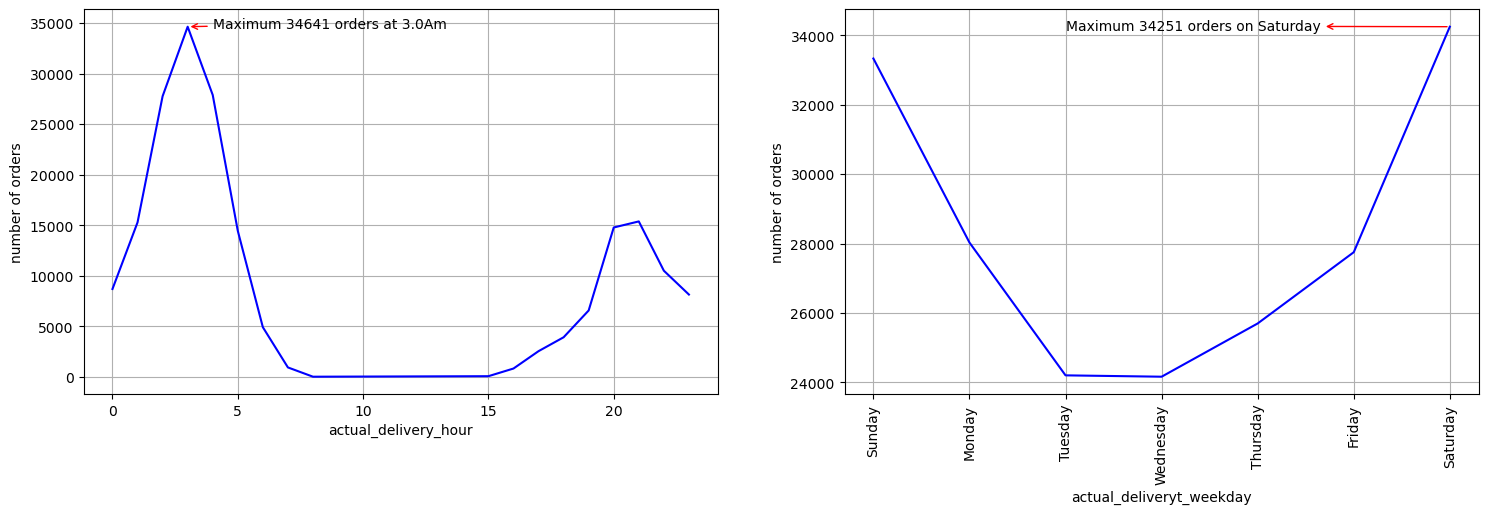

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

print(f"feature actual_delivery_hour - ")
shapiro_test(df.actual_delivery_hour)
print(f"skew = {skew_info.loc['actual_delivery_hour']} \n")
print(f"average time for delivery = {df.delivery_time.mean().round(2)}")

df["actual_delivery_hour"].value_counts().sort_index().plot(kind = "line", grid = True, ylabel = "number of orders", color = "blue", ax = ax[0])
max_value = df["actual_delivery_hour"].value_counts().max()
max_index = df["actual_delivery_hour"].value_counts().idxmax()

ax[0].annotate(f'Maximum {max_value} orders at {max_index}Am', xy=(max_index, max_value), xytext=(max_index+1, max_value - 100), arrowprops=dict(arrowstyle='->', color = "red"))

day_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
df["actual_deliveryt_weekday"].value_counts().reindex(day_order).plot(kind="line", grid=True, ylabel="number of orders", color="blue", ax = ax[1])
plt.xticks(rotation=90)

max_value = df["actual_deliveryt_weekday"].value_counts().max()
max_index = df["actual_deliveryt_weekday"].value_counts().idxmax()

ax[1].annotate(f'Maximum {max_value} orders on {max_index}', xy=(day_order.index(max_index), max_value), xytext=(day_order.index(max_index) - 4, max_value - 100), arrowprops=dict(arrowstyle='<-', color="red"))
plt.show()

In [28]:
df.actual_delivery_month.value_counts()

actual_delivery_month
February    129191
January      68230
Name: count, dtype: int64

> the data contains the the orders that are delievred in January, February

- and order placed in october might be an outler, and it is delivered in Jan or Feb

In [29]:
df[df.created_at_month == "October"]
# this seems like an outlier

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_busy_partners,total_outstanding_orders,created_at_month,created_at_weekday,created_at_hour,actual_delivery_month,actual_deliveryt_weekday,actual_delivery_hour,delivery_time,is_weekend
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,675f9820626f5bc0afb47b57890b466e,italian,1.0,1,1695,1,1595,...,NaN,NaN,October,Sunday,5,January,Sunday,19.0,141947.65,1


In [30]:
print(f"the minimum delivery time = {df.delivery_time.min()} minutes")
print(f"the maximum delivery time = {df.delivery_time.max()} minutes -> {df.delivery_time.max()/60} hours -> {df.delivery_time.max()/(24 * 60)} days")

the minimum delivery time = 1.6833333333333333 minutes
the maximum delivery time = 141947.65 minutes -> 2365.7941666666666 hours -> 98.57475694444445 days


feature subtotal - 
Sample does not look Gaussian (reject H0)
skew = 1.96 



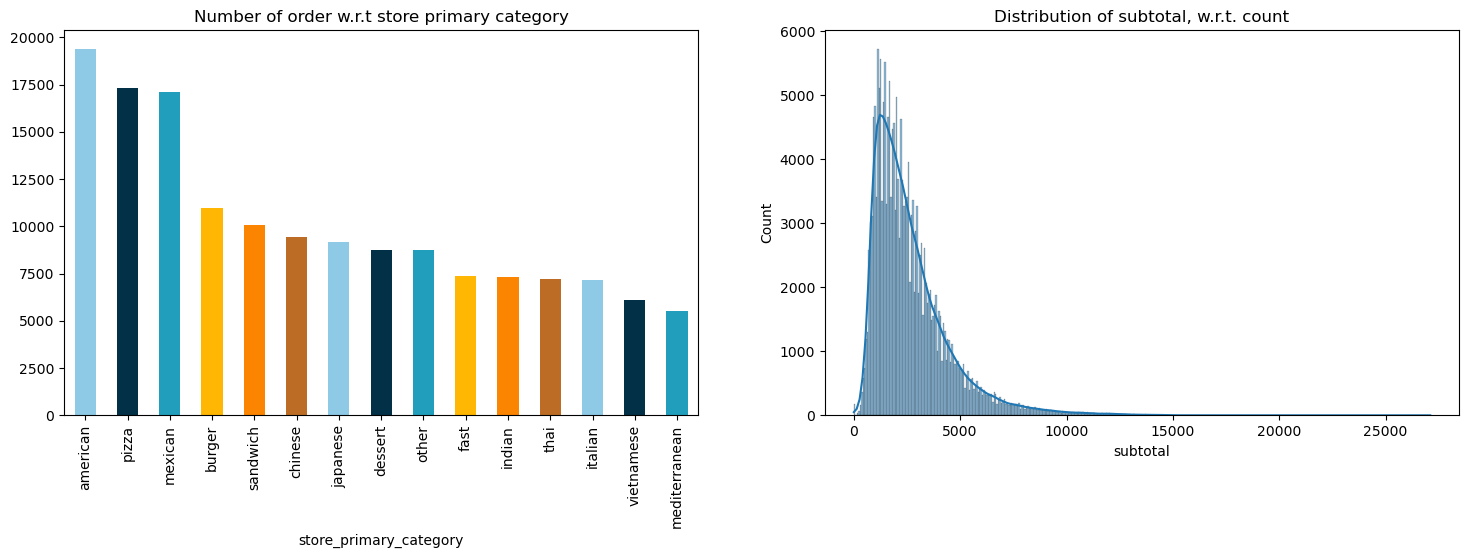

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

print(f"feature subtotal - ")
shapiro_test(df.subtotal)
print(f"skew = {skew_info.loc['subtotal']} \n")

df.store_primary_category.value_counts().head(15).plot(kind = "bar", color = color, ax = ax[0])
ax[0].set_title("Number of order w.r.t store primary category")

sns.histplot(df.subtotal, ax = ax[1], kde = True)
ax[1].set_title("Distribution of subtotal, w.r.t. count")
plt.show()

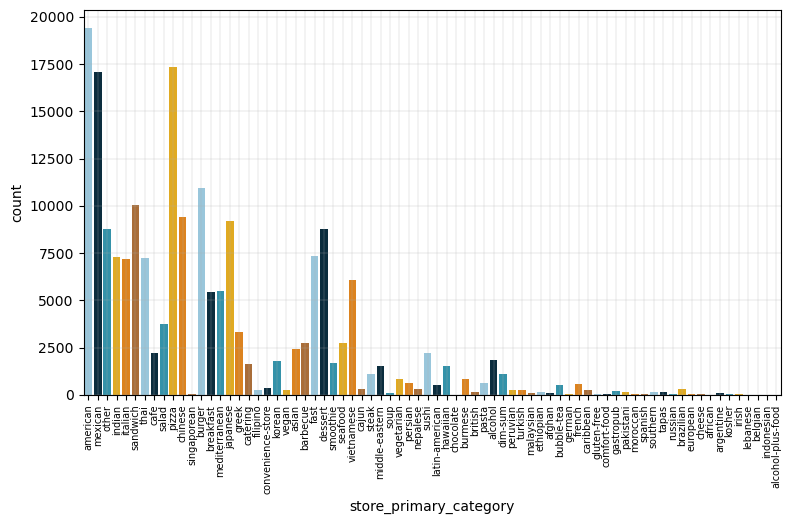

In [32]:
sns.countplot(x = df.store_primary_category, palette = color)
plt.xticks(rotation = 90, fontsize = 7)
plt.grid(True, linewidth = 0.2)
plt.show()

feature total_onshift_partners - 
Sample looks Gaussian (fail to reject H0)
skew = 0.86 

feature total_busy_partners - 
Sample looks Gaussian (fail to reject H0)
skew = 0.78 



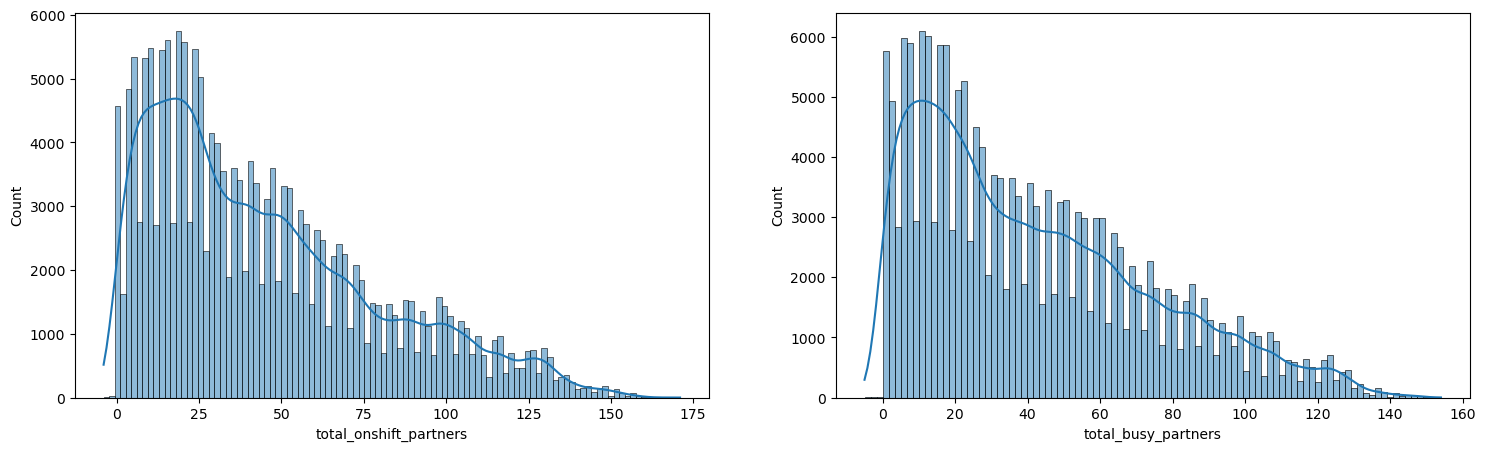

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

print(f"feature total_onshift_partners - ")
shapiro_test(df.total_onshift_partners)
print(f"skew = {skew_info.loc['total_onshift_partners']} \n")

print(f"feature total_busy_partners - ")
shapiro_test(df.total_busy_partners)
print(f"skew = {skew_info.loc['total_busy_partners']} \n")

sns.histplot(df.total_onshift_partners, ax = ax[0], kde = True)
sns.histplot(df.total_busy_partners, ax = ax[1], kde = True)
plt.show()

feature total_outstanding_orders - 
Sample looks Gaussian (fail to reject H0)
skew = 1.2 



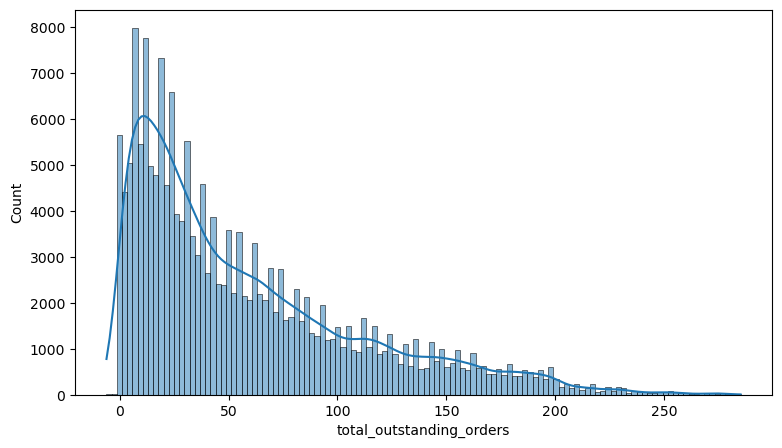

In [34]:
print(f"feature total_outstanding_orders - ")
shapiro_test(df.total_outstanding_orders)
print(f"skew = {skew_info.loc['total_outstanding_orders']} \n")

sns.histplot(df.total_outstanding_orders, kde = True)
plt.show()

feature min_item_price - 
Sample does not look Gaussian (reject H0)
skew = 2.33 

feature max_item_price - 
Sample does not look Gaussian (reject H0)
skew = 2.2 



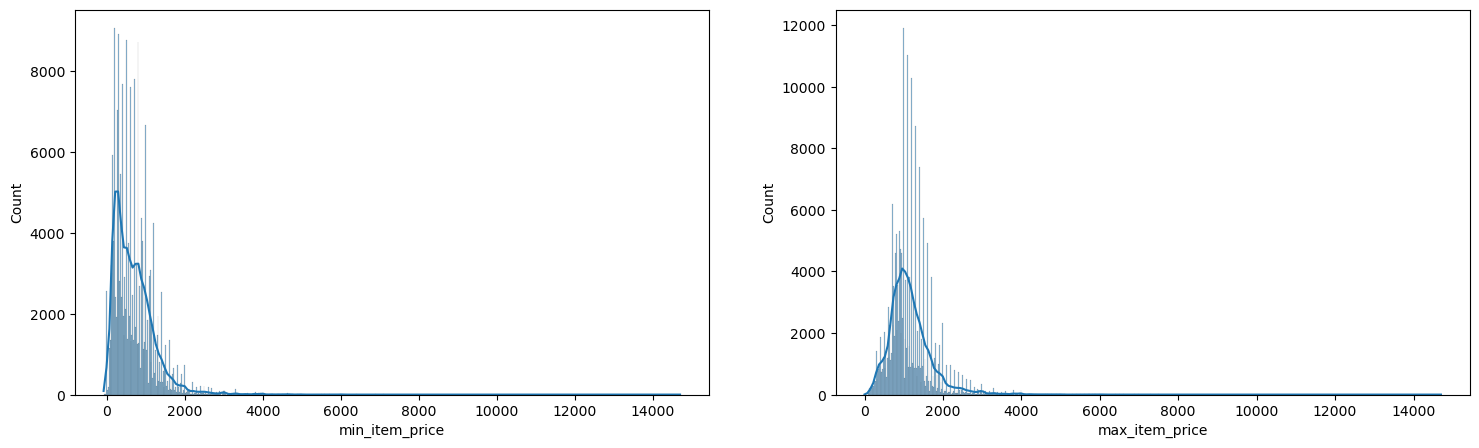

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

print(f"feature min_item_price - ")
shapiro_test(df.min_item_price)
print(f"skew = {skew_info.loc['min_item_price']} \n")

print(f"feature max_item_price - ")
shapiro_test(df.max_item_price)
print(f"skew = {skew_info.loc['max_item_price']} \n")

sns.histplot(df.min_item_price, ax = ax[0], kde = True)
sns.histplot(df.max_item_price, ax = ax[1], kde = True)
plt.show()

feature delivery_time - 
Sample does not look Gaussian (reject H0)
skew = 439.7 



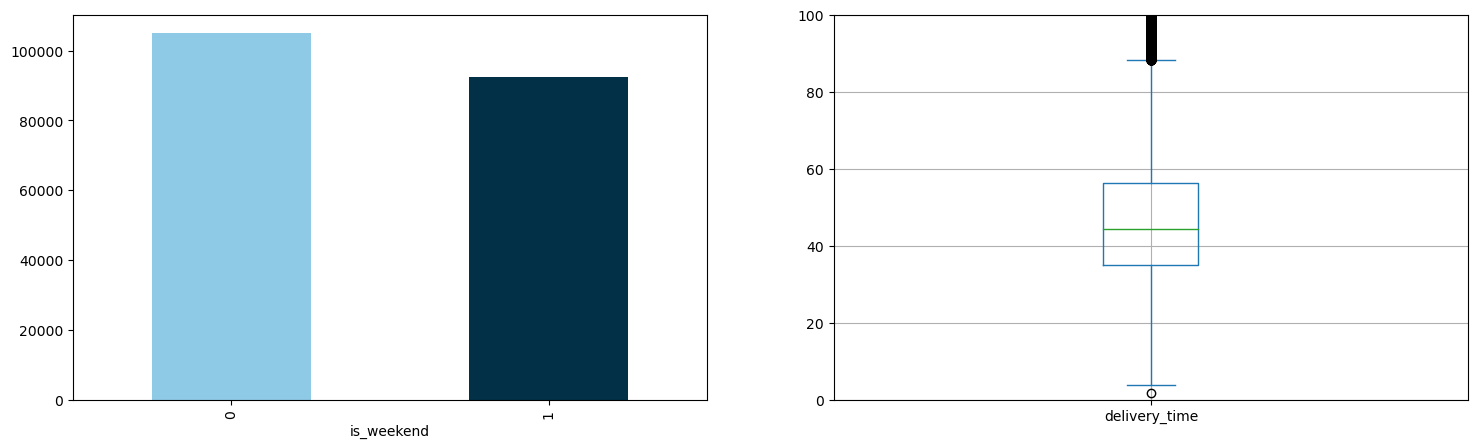

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

print(f"feature delivery_time - ")
shapiro_test(df.delivery_time)
print(f"skew = {skew_info.loc['delivery_time']} \n")

df.is_weekend.value_counts(sort = False, dropna = False).plot(kind = "bar", color = color, ax = ax[0])
df.delivery_time.plot(kind = "box", label = "delivery_time", grid = True, ax = ax[1])
ax[1].set_ylim(0,100)
plt.show()

- Most of the order are from Market 2, 4 (there are some NaN values too, imputing with mode might increase bias and increase the count of Market id 2)
- order protocols 1,3,5 are being used most for ordering
- the number of distinct items, and total items are of 2 items per order (if a person is ordering 1 item, then we can provide some coupon to make him add another item, let's check it later)
- Most of the orders are at early morning 2Am and on weekends
- On an average it is taking 48 mins to deliver the order (there might be some ouliers which is effecting the average delivery time)
- American, pizza, mexican are top ordered categories from stores 
- the negative values in ***min_item_price***, ***total_onshift_partners***, ***total_busy_partners***, ***total_outstanding_orders*** as discussed earlier

### Bi-variate & Multi-variate Analysis

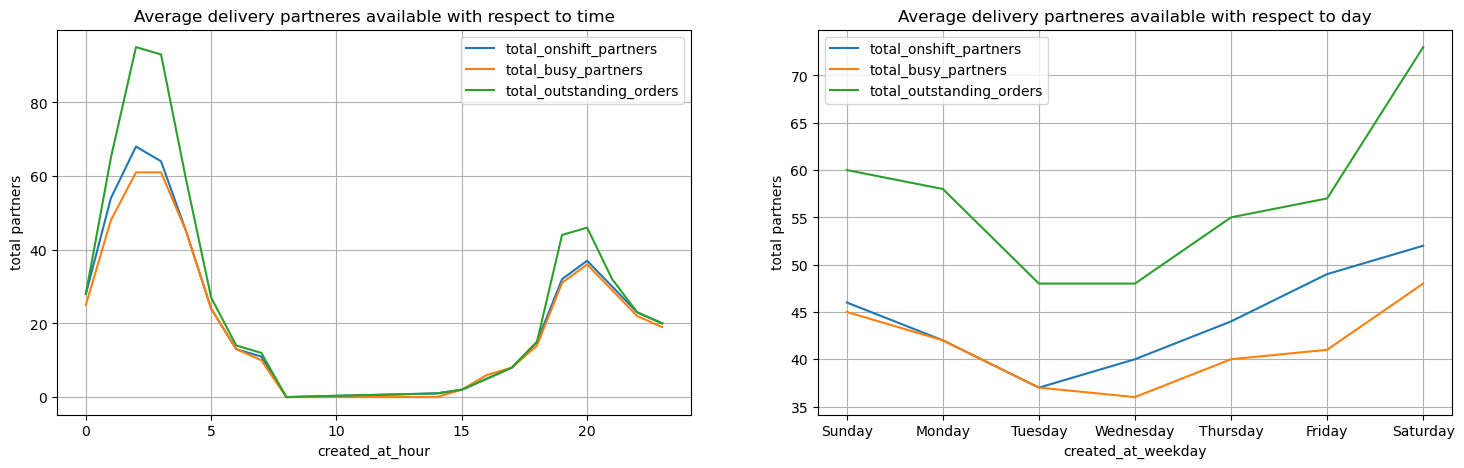

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
df.groupby(by = ["created_at_hour"])[["total_onshift_partners", "total_busy_partners", "total_outstanding_orders"]].mean().round().plot(kind = "line", grid = True, ax = ax[0])
ax[0].set_title("Average delivery partneres available with respect to time")
ax[0].set_ylabel("total partners")

df.groupby(by = ["created_at_weekday"])[["total_onshift_partners", "total_busy_partners", "total_outstanding_orders"]].mean().round().loc[day_order, :].plot(kind = "line", grid = True, ax = ax[1])
ax[1].set_title("Average delivery partneres available with respect to day")
ax[1].set_ylabel("total partners")
plt.show()

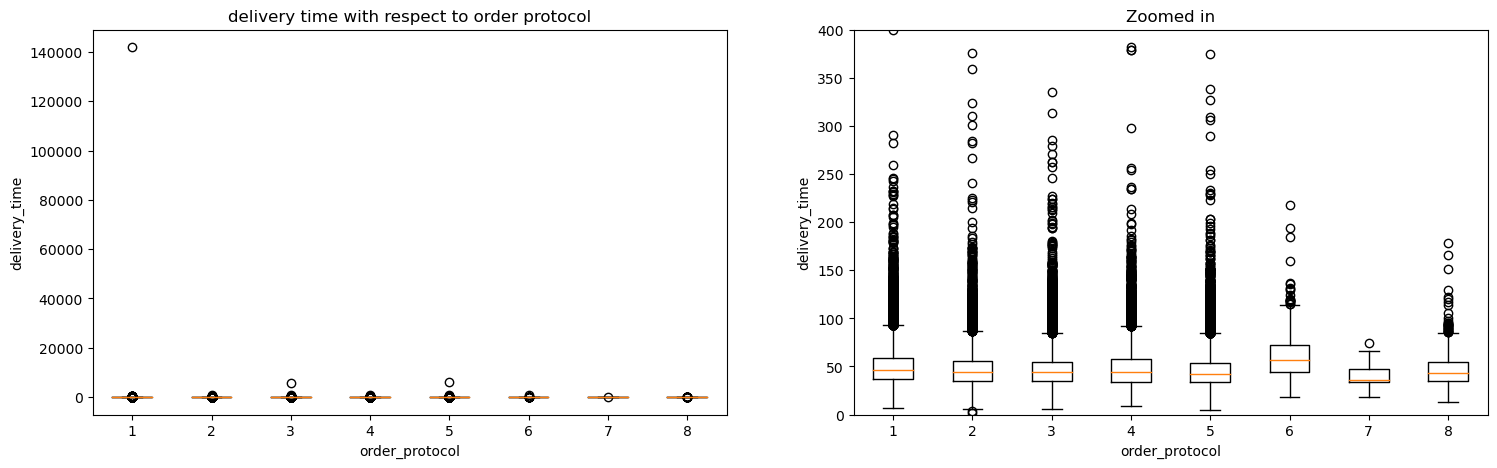

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

boxplot_data = [group[1] for group in df.groupby(by = ["order_protocol"])["delivery_time"]]
ax[0].boxplot(boxplot_data)
ax[0].set_xlabel("order_protocol")
ax[0].set_ylabel("delivery_time")
ax[0].set_title("delivery time with respect to order protocol")

ax[1].boxplot(boxplot_data)
ax[1].set_xlabel("order_protocol")
ax[1].set_ylabel("delivery_time")
ax[1].set_title("Zoomed in")
ax[1].set_ylim(0, 400)  
plt.show()


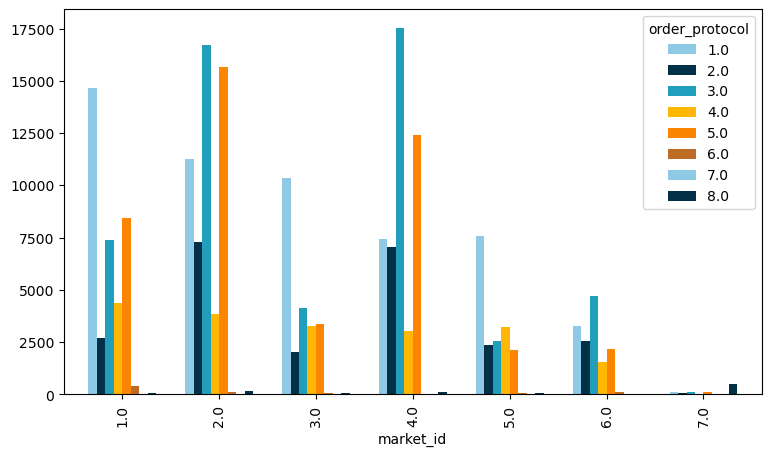

In [39]:
df.groupby(by = ["market_id", "order_protocol"])["order_protocol"].apply("count").unstack().plot(kind='bar', stacked=False, width=0.7, color = color)
plt.show()

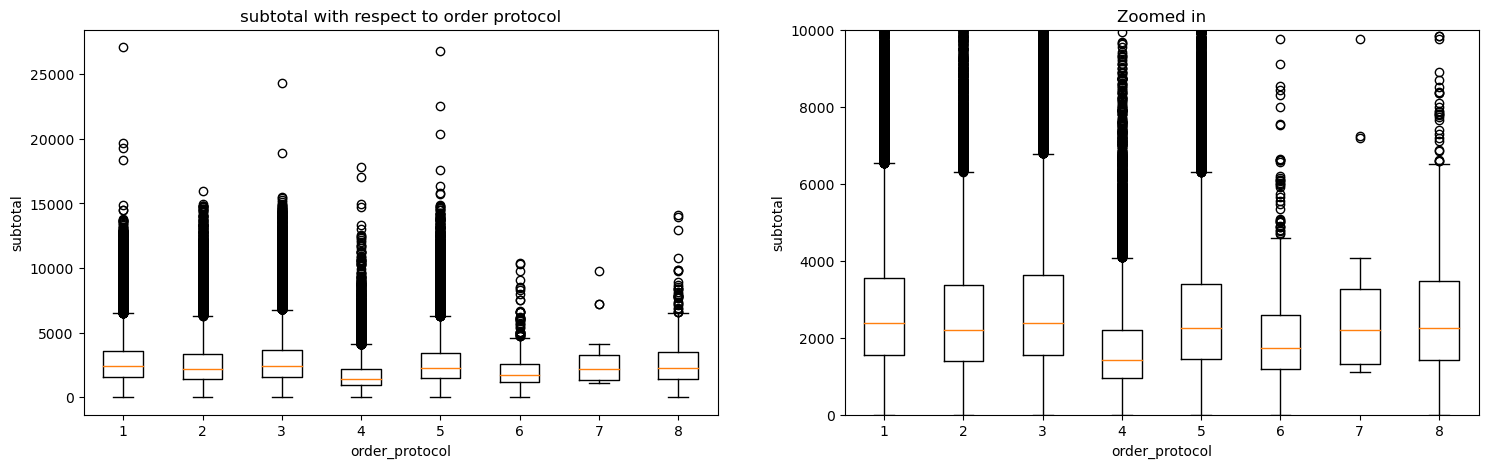

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

boxplot_data = [group[1] for group in df.groupby(by = ["order_protocol"])["subtotal"]]
ax[0].boxplot(boxplot_data)
ax[0].set_xlabel("order_protocol")
ax[0].set_ylabel("subtotal")
ax[0].set_title("subtotal with respect to order protocol")

ax[1].boxplot(boxplot_data)
ax[1].set_xlabel("order_protocol")
ax[1].set_ylabel("subtotal")
ax[1].set_title("Zoomed in")
ax[1].set_ylim(0, 10000)  
plt.show()


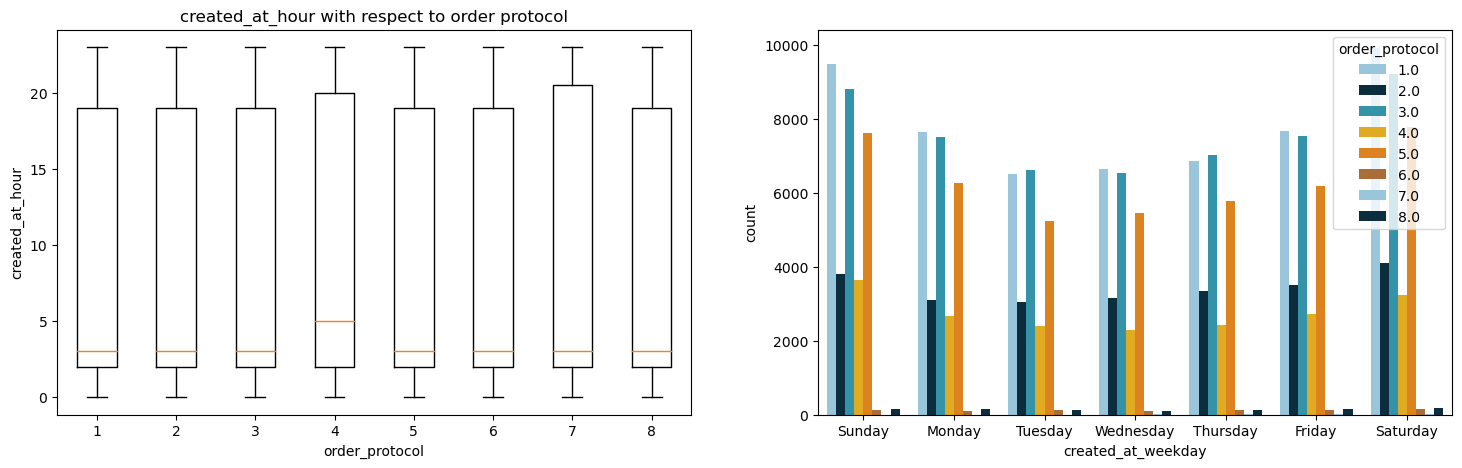

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

boxplot_data = [group[1] for group in df.groupby(by = ["order_protocol"])["created_at_hour"]]
ax[0].boxplot(boxplot_data)
ax[0].set_xlabel("order_protocol")
ax[0].set_ylabel("created_at_hour")
ax[0].set_title("created_at_hour with respect to order protocol")

sns.countplot(hue = df.order_protocol, x = df.created_at_weekday, order = day_order, palette = color, ax = ax[1])
plt.show()


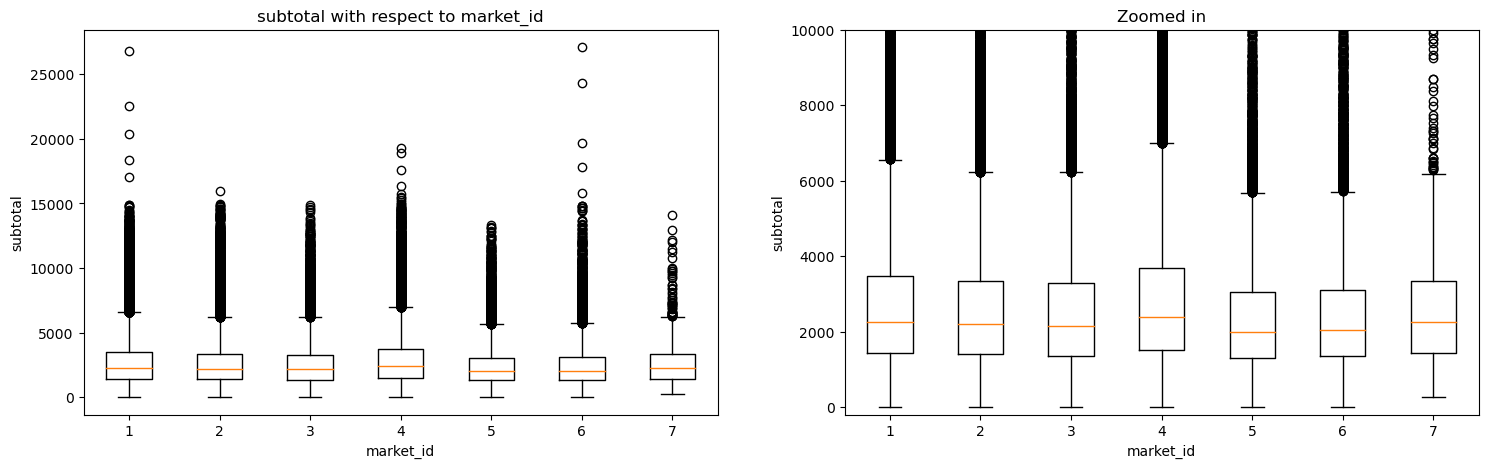

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

boxplot_data = [group[1] for group in df.groupby(by = ["market_id"])["subtotal"]]
ax[0].boxplot(boxplot_data)
ax[0].set_xlabel("market_id")
ax[0].set_ylabel("subtotal")
ax[0].set_title("subtotal with respect to market_id")

ax[1].boxplot(boxplot_data)
ax[1].set_xlabel("market_id")
ax[1].set_ylabel("subtotal")
ax[1].set_title("Zoomed in")
ax[1].set_ylim(-200, 10000)  
plt.show()

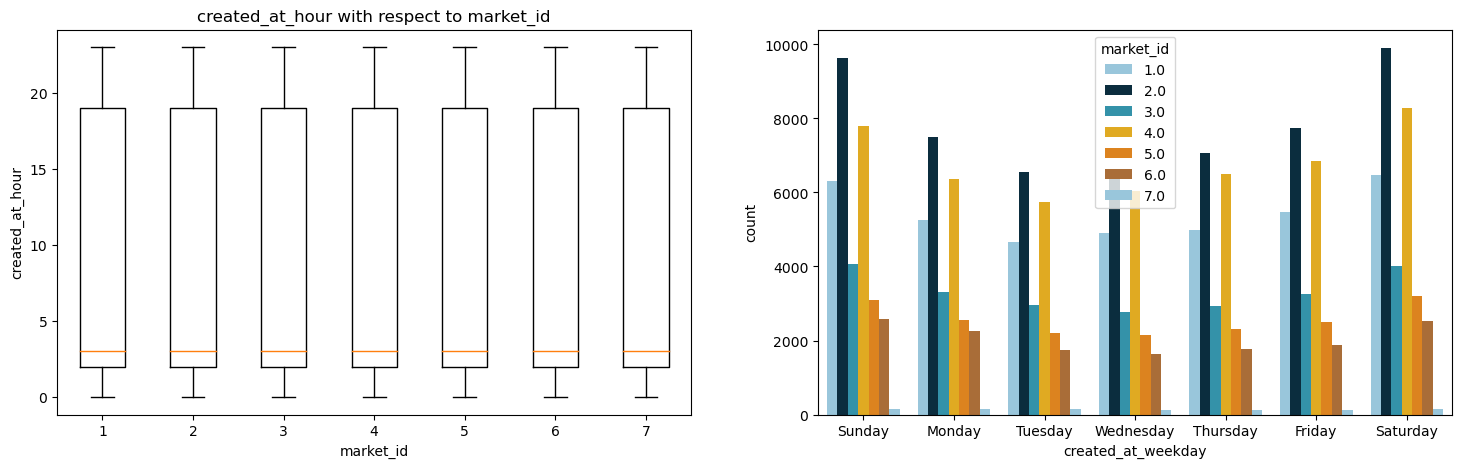

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

boxplot_data = [group[1] for group in df.groupby(by = ["market_id"])["created_at_hour"]]
ax[0].boxplot(boxplot_data)
ax[0].set_xlabel("market_id")
ax[0].set_ylabel("created_at_hour")
ax[0].set_title("created_at_hour with respect to market_id")

sns.countplot(hue = df.market_id, x = df.created_at_weekday, order = day_order, palette = color, ax = ax[1])
plt.show()


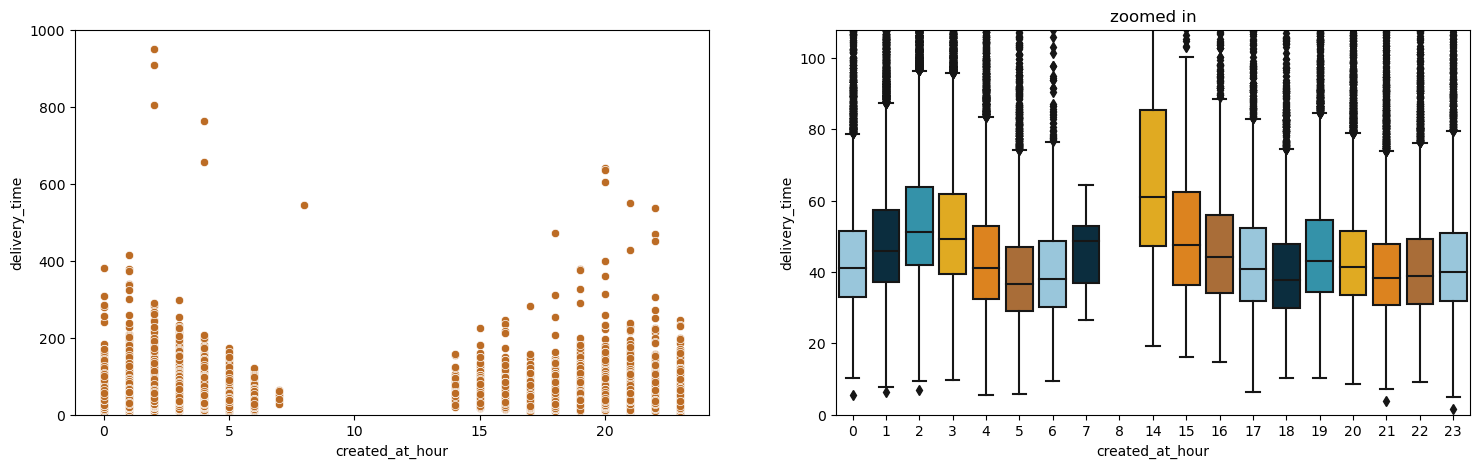

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.scatterplot(x = df.created_at_hour, y = df.delivery_time, ax = ax[0], color = color[5])
ax[0].set_ylim(0,1000)

sns.boxplot(x = df.created_at_hour, y = df.delivery_time, ax = ax[1], palette = color)
ax[1].set_ylim(0,107.91333333333314)
ax[1].set_title("zoomed in")
plt.show()

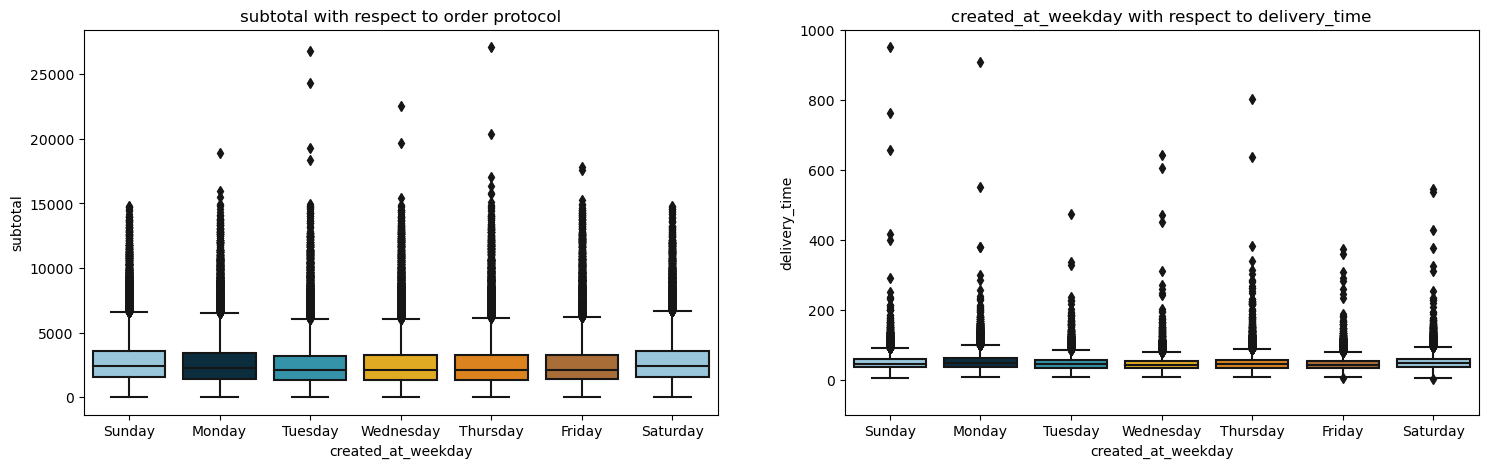

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

sns.boxplot(x = df.created_at_weekday, y = df.subtotal, palette = color, ax = ax[0], order = day_order)
ax[0].set_xlabel("created_at_weekday")
ax[0].set_ylabel("subtotal")
ax[0].set_title("subtotal with respect to order protocol")

sns.boxplot(x = df.created_at_weekday, y = df.delivery_time, palette = color, ax = ax[1],  order = day_order)
ax[1].set_xlabel("created_at_weekday")
ax[1].set_ylabel("delivery_time")
ax[1].set_title("created_at_weekday with respect to delivery_time")
ax[1].set_ylim(-100, 1000)
plt.show()


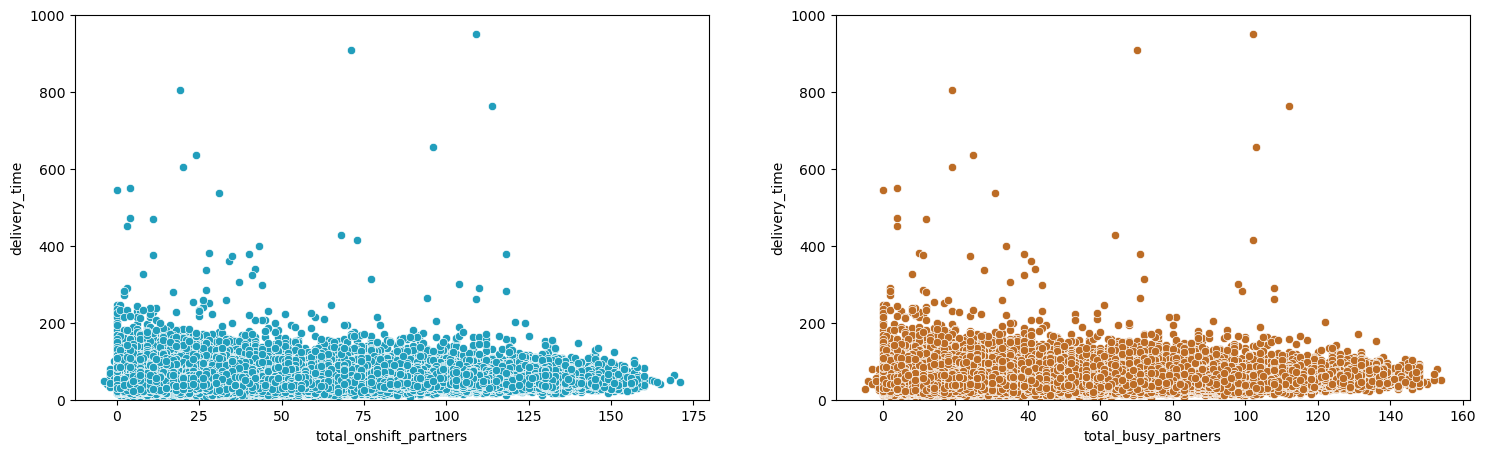

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

sns.scatterplot(x = df.total_onshift_partners, y = df.delivery_time, ax = ax[0], color = color[2])
ax[0].set_ylim(0, 1000)

sns.scatterplot(x = df.total_busy_partners, y = df.delivery_time, ax = ax[1], color = color[5])
ax[1].set_ylim(0, 1000)

plt.show()

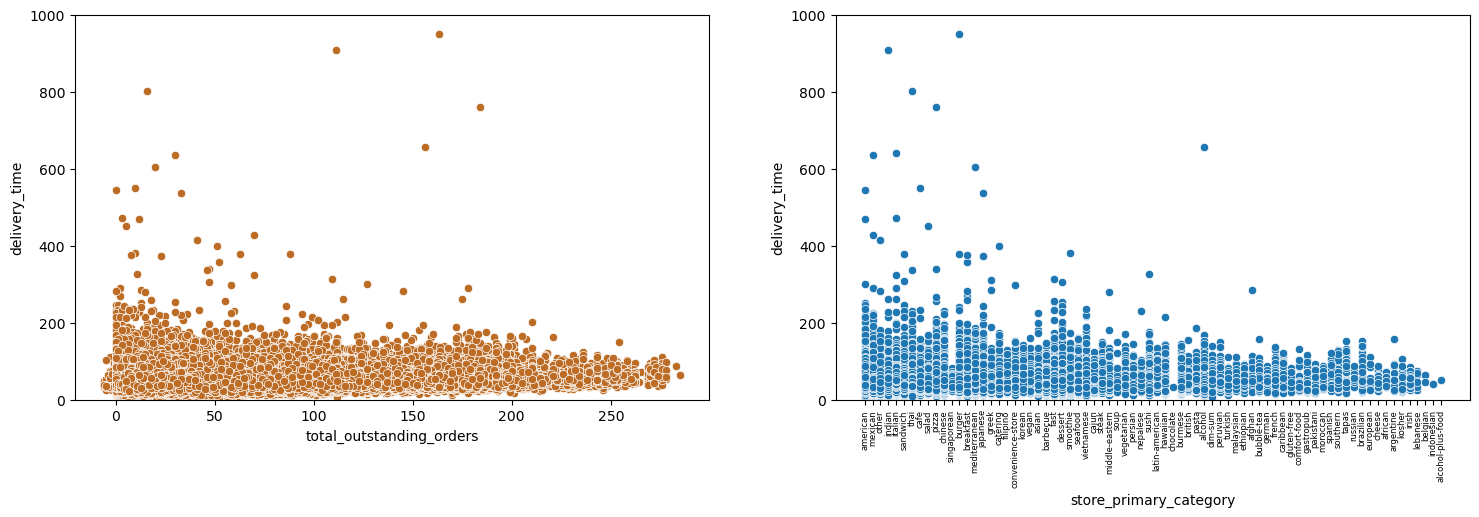

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

sns.scatterplot(x = df.total_outstanding_orders, y = df.delivery_time, color = color[5], ax = ax[0])
ax[0].set_ylim(0, 1000)

sns.scatterplot(x = df.store_primary_category, y = df.delivery_time, ax = ax[1])
ax[1].set_ylim(0, 1000)
ax[1].tick_params(axis='x', rotation=90, labelsize = 6)
plt.show()

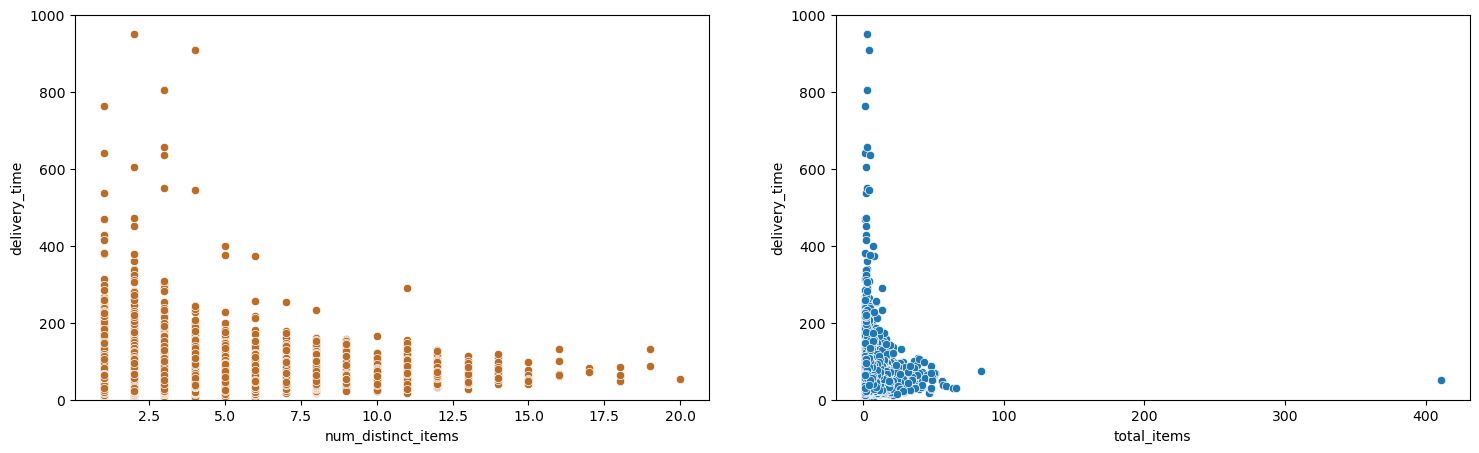

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.scatterplot(x = df.num_distinct_items, y = df.delivery_time, ax = ax[0], color = color[5])
ax[0].set_ylim(0,1000)

sns.scatterplot(x = df.total_items, y = df.delivery_time, ax = ax[1], palette = color)
ax[1].set_ylim(0,1000)
plt.show()

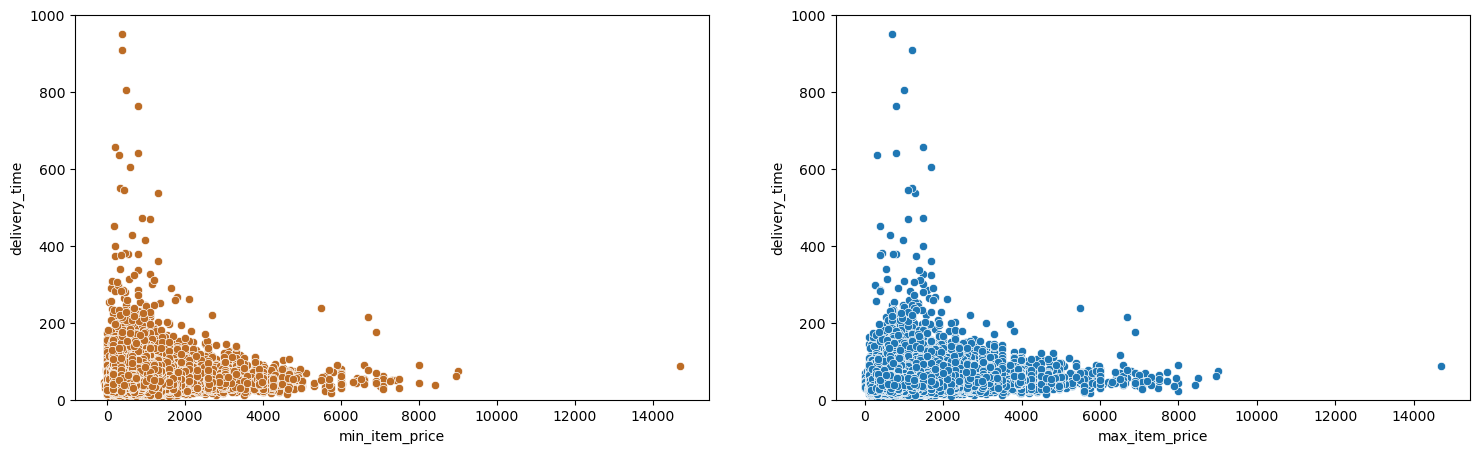

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.scatterplot(x = df.min_item_price, y = df.delivery_time, ax = ax[0], color = color[5])
ax[0].set_ylim(0,1000)

sns.scatterplot(x = df.max_item_price, y = df.delivery_time, ax = ax[1], palette = color)
ax[1].set_ylim(0,1000)
plt.show()

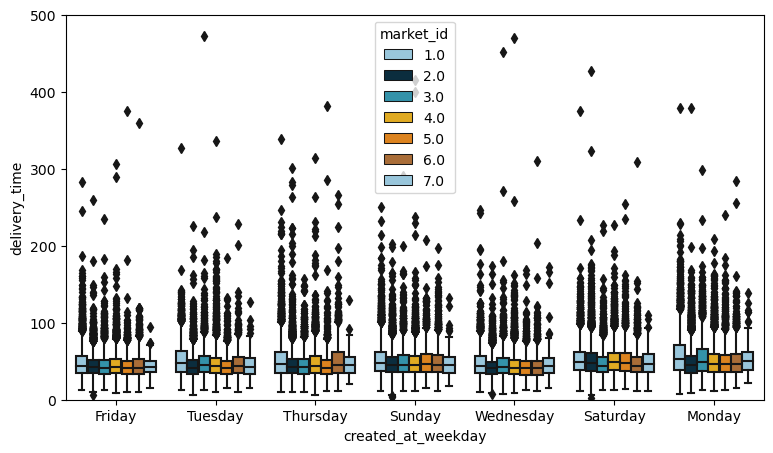

In [51]:
sns.boxplot(x = df.created_at_weekday, y = df.delivery_time, hue = df.market_id, palette = color)
plt.ylim(0,500)
plt.show()

- there is a gap between, outstanding orders and total available partners at peak time
- the median delivery time for orders ordered from protocol 7 is less (but there are very less orders from the same protocol)
- orders from order protocols are varying with respect to market_id
- the median of subtotal is less for orders ordered from protocol 4

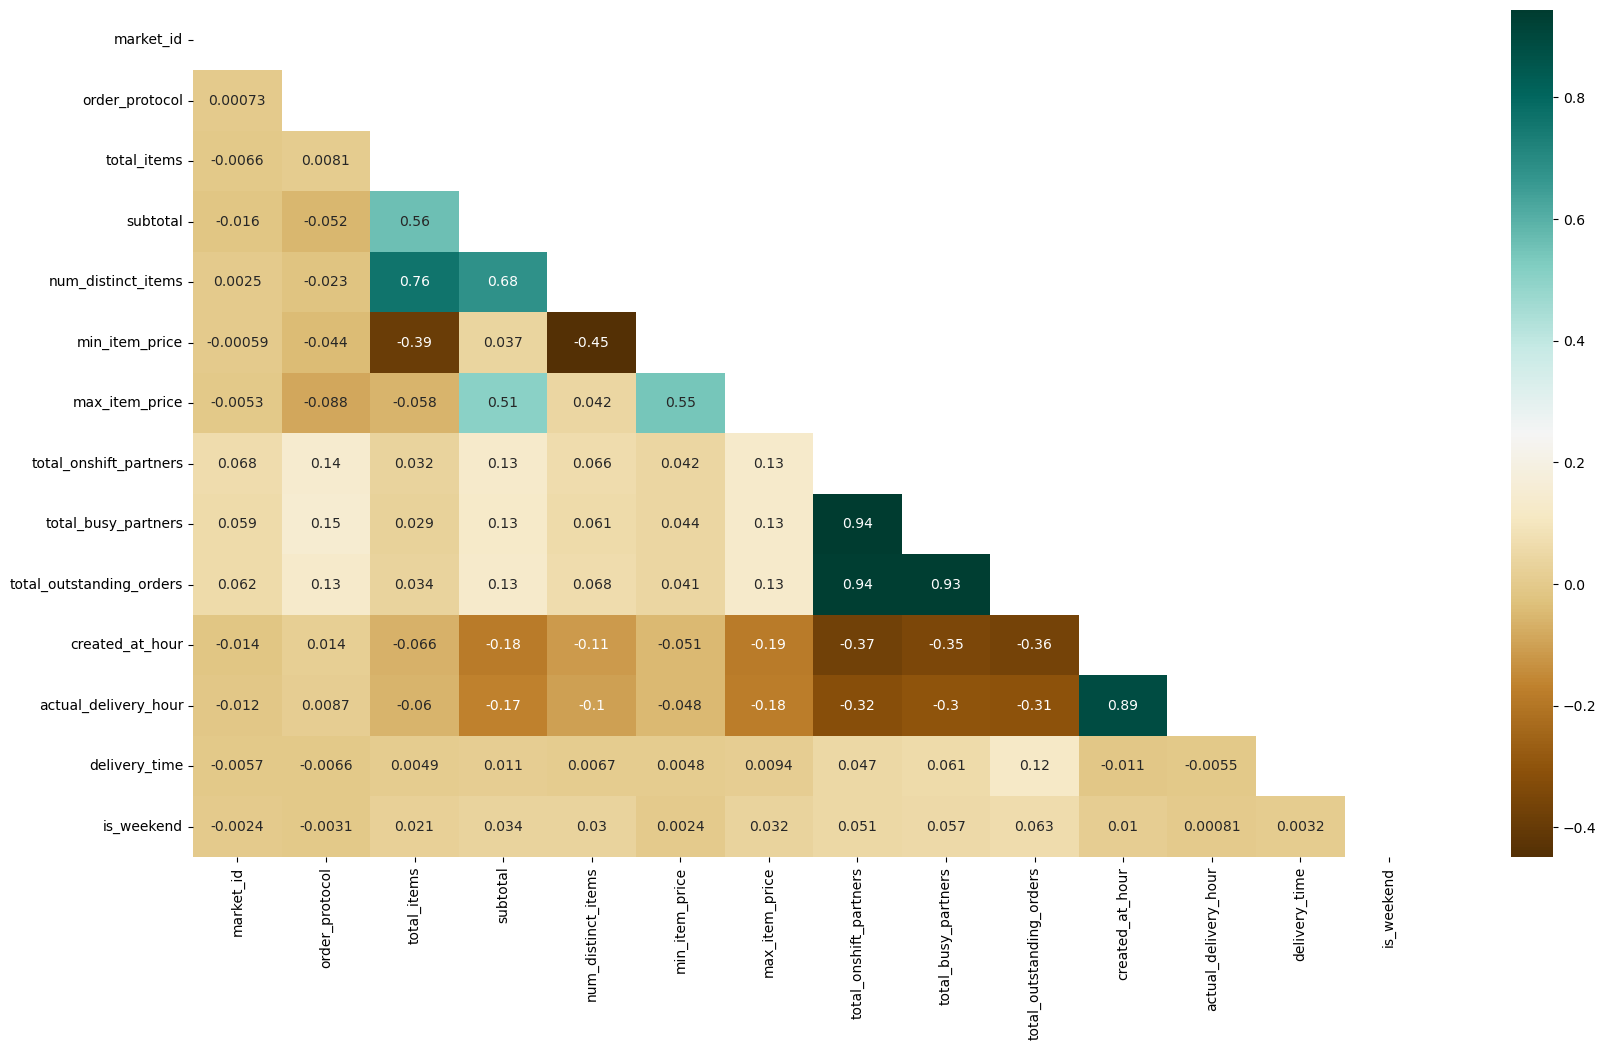

In [52]:
fig, ax = plt.subplots(figsize=(20,11))
sns.heatmap(df[numerical_cols].corr(), annot = True, cmap = 'BrBG', ax = ax, mask = np.triu(np.ones_like(df[numerical_cols].corr(), dtype=bool)))
plt.show()

## Model

### simple linear regression model

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_sca, y_train)
y_train_pred = model.predict(X_train_sca)
y_test_pred = model.predict(X_test_sca)

#### linear regression model metrics

In [17]:
print(f"training data\n{'-'*30}\n  mse = {mean_squared_error(y_train, y_train_pred)}\n  mae = {mean_absolute_error(y_train, y_train_pred)}\n  mape = {mean_absolute_percentage_error(y_train, y_train_pred)}\n  r2_score = {r2_score(y_train, y_train_pred)}\n  rmse = {np.sqrt(mean_squared_error(y_train, y_train_pred))}\n")
print(f"test data\n{'-'*30}\n  mse = {mean_squared_error(y_test, y_test_pred)}\n  mae = {mean_absolute_error(y_test, y_test_pred)}\n  mape = {mean_absolute_percentage_error(y_test, y_test_pred)}\n  r2_score = {r2_score(y_test, y_test_pred)}\n  rmse = {np.sqrt(mean_squared_error(y_test, y_test_pred))}")

training data
------------------------------
  mse = 197.25098480238145
  mae = 10.695340621978024
  mape = 0.2489888999589263
  r2_score = 0.308920283208586
  rmse = 14.044606965037557

test data
------------------------------
  mse = 207.79763873985047
  mae = 10.971984113637056
  mape = 0.25389797539000925
  r2_score = 0.2868895698497178
  rmse = 14.41518778024936


### XGBoost Regressor

In [18]:
model = XGBRegressor()
model.fit(X_train_sca, y_train)
y_train_pred = model.predict(X_train_sca)
y_test_pred = model.predict(X_test_sca)

In [19]:
print(f"training data\n{'-'*30}\n  mse = {mean_squared_error(y_train, y_train_pred)}\n  mae = {mean_absolute_error(y_train, y_train_pred)}\n  mape = {mean_absolute_percentage_error(y_train, y_train_pred)}\n  r2_score = {r2_score(y_train, y_train_pred)}\n  rmse = {np.sqrt(mean_squared_error(y_train, y_train_pred))}\n")
print(f"test data\n{'-'*30}\n  mse = {mean_squared_error(y_test, y_test_pred)}\n  mae = {mean_absolute_error(y_test, y_test_pred)}\n  mape = {mean_absolute_percentage_error(y_test, y_test_pred)}\n  r2_score = {r2_score(y_test, y_test_pred)}\n  rmse = {np.sqrt(mean_squared_error(y_test, y_test_pred))}")

training data
------------------------------
  mse = 159.57783419878044
  mae = 9.581537482160911
  mape = 0.22292344902415073
  r2_score = 0.44091024653303046
  rmse = 12.632412049912734

test data
------------------------------
  mse = 192.66785365273094
  mae = 10.496897078659268
  mape = 0.24191252731937185
  r2_score = 0.3388112741433096
  rmse = 13.88048463320827


Text(0.5, 0, 'XGBoost Feature Importance')

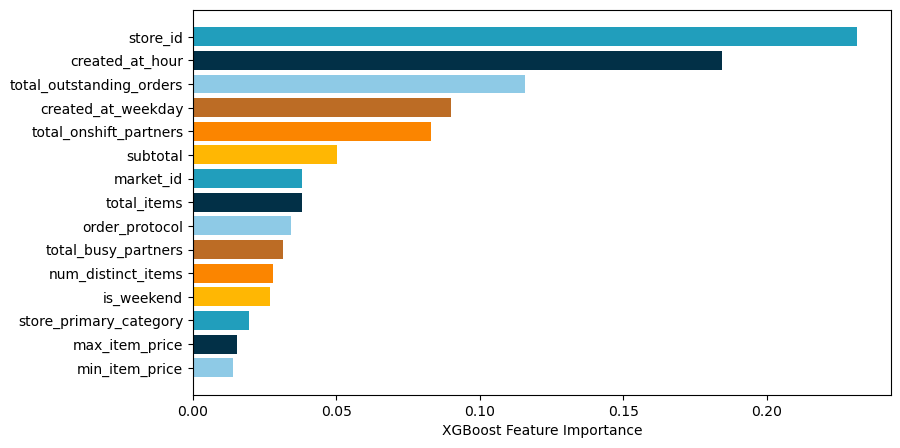

In [20]:
sorted_idx=model.feature_importances_.argsort()
plt.barh(features[sorted_idx],model.feature_importances_[sorted_idx], color = color)
plt.xlabel("XGBoost Feature Importance")

### Neural Network Model

#### autoencoder - to remove any noise present

In [33]:
#AutoEncoder model - Functional
input_layer = keras.Input(shape=(X_train.shape[1],))
encoded = Dense(1024, activation='relu')(input_layer)
encoded = Dense(512, activation='relu')(encoded)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(1024, activation='relu')(decoded)
decoded = Dense(X_train.shape[1], activation='linear')(decoded)

In [34]:
EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7,  restore_best_weights=True, verbose=1)
ModelCheckpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath='tf_model.h5',
                                                             monitor='val_loss',
                                                             save_best_only=True,
                                                             mode='min', verbose = 1)

In [36]:
now = datetime.now()
log_folder = "tf_logs/.../" + now.strftime("%Y%m%d-%H%M%S") + "/"

tb_callback = TensorBoard(log_dir=log_folder, histogram_freq=1)

In [37]:
autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(X_train_sca, X_train_sca,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_split = 0.2,
                callbacks = [EarlyStoppingCallback, ModelCheckpointCallback])

Epoch 1/50
1962/1963 [============================>.] - ETA: 0s - loss: 0.1019
Epoch 1: val_loss improved from inf to 0.05067, saving model to tf_model.h5
1963/1963 [==============================] - 20s 10ms/step - loss: 0.1019 - val_loss: 0.0507
Epoch 2/50
1958/1963 [============================>.] - ETA: 0s - loss: 0.0653
Epoch 2: val_loss improved from 0.05067 to 0.04718, saving model to tf_model.h5
1963/1963 [==============================] - 20s 10ms/step - loss: 0.0653 - val_loss: 0.0472
Epoch 3/50
1960/1963 [============================>.] - ETA: 0s - loss: 0.0490
Epoch 3: val_loss did not improve from 0.04718
1963/1963 [==============================] - 22s 11ms/step - loss: 0.0490 - val_loss: 0.0484
Epoch 4/50
1962/1963 [============================>.] - ETA: 0s - loss: 0.0449
Epoch 4: val_loss did not improve from 0.04718
1963/1963 [==============================] - 23s 12ms/step - loss: 0.0450 - val_loss: 0.1906
Epoch 5/50
1961/1963 [============================>.] - ETA: 0

In [38]:
from sklearn.metrics import r2_score

train_r2 = r2_score(y_true = X_train_sca, y_pred = autoencoder.predict(X_train_sca))
test_r2 = r2_score(y_true = X_test_sca, y_pred = autoencoder.predict(X_test_sca))

print(f"training score = {train_r2}\ntesting score = {test_r2}")

1227/1227 [==============================] - 3s 2ms/step
training score = 0.9681877426484206
testing score = 0.9704199868855383


In [40]:
X_train = autoencoder.predict(X_train_sca)
X_test = autoencoder.predict(X_test_sca)

1227/1227 [==============================] - 3s 2ms/step


#### optuna - hyper parameter tuning

In [57]:
X_train_sca.shape

(156994, 15)

In [66]:
def create_model(trial):
    input_layer = Input(shape=(X_train_sca.shape[1], ))
    hidden_layer = Dense(15, activation = "relu")(input_layer)
    n_layers = trial.suggest_int('n_layers', 1, 6)
    for i in range(n_layers):
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 32, 512)
        hidden_layer = Dense(num_hidden, activation='relu')(hidden_layer)
    output_layer = Dense(1, activation = 'linear')(hidden_layer)
    model = tf.keras.Model(inputs = input_layer, outputs = output_layer)
    return model

In [67]:
def objective(trial):
    model = create_model(trial)
    model.compile(optimizer = "adam", loss='mse', metrics=["mse", "mape", R2Score()])

    batch_size = trial.suggest_categorical('batch_size', [16, 32,64, 128])
    epochs = 30  # Keeping epochs fixed for demonstration; you might want to tune this as well

    model.fit(X_train, y_train, validation_split=0.2, shuffle=True, batch_size=batch_size, epochs=epochs, verbose=1)

    # Evaluate the model accuracy on the validation set
    score = model.evaluate(X_test, y_test, verbose=1)
    return score[1]  # Return the accuracy

In [68]:
# 4. Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # You can increase n_trials for a more thorough search

# 5. Print the best hyperparameters
print('Best trial:', study.best_trial.params)

# Optional: Evaluate the best model on the test set
best_model = create_model(study.best_trial)
best_model.compile(optimizer = "adam", loss='mse', metrics=["mae", "mape", R2Score()])
best_model.fit(X_train, y_train, batch_size=study.best_trial.params['batch_size'], epochs=10, verbose=1)
test_metrics = best_model.evaluate(X_test, y_test)
print(f"test data\n{'-'*30}\n  mse = {test_metrics[0]}\n  mae = {test_metrics[1]}\n  mape = {test_metrics[2]}\n  r2_score = {test_metrics[3]}\n  rmse = {np.sqrt(test_metrics[0])}")

[I 2024-03-18 13:22:16,984] A new study created in memory with name: no-name-2f773e55-8168-46a5-9b73-d51d5d408a49


Epoch 1/30
982/982 [==============================] - 4s 3ms/step - loss: 270.1727 - mse: 270.1727 - mape: 28.2573 - r2_score: 0.0544 - val_loss: 215.2278 - val_mse: 215.2278 - val_mape: 26.3479 - val_r2_score: 0.2426
Epoch 2/30
982/982 [==============================] - 3s 3ms/step - loss: 215.1026 - mse: 215.1026 - mape: 26.0668 - r2_score: 0.2472 - val_loss: 214.4536 - val_mse: 214.4536 - val_mape: 26.7894 - val_r2_score: 0.2453
Epoch 3/30
982/982 [==============================] - 3s 3ms/step - loss: 213.3279 - mse: 213.3279 - mape: 25.9925 - r2_score: 0.2534 - val_loss: 212.7424 - val_mse: 212.7424 - val_mape: 26.1178 - val_r2_score: 0.2514
Epoch 4/30
982/982 [==============================] - 3s 4ms/step - loss: 211.0966 - mse: 211.0966 - mape: 25.8613 - r2_score: 0.2612 - val_loss: 210.9215 - val_mse: 210.9215 - val_mape: 25.7496 - val_r2_score: 0.2578
Epoch 5/30
982/982 [==============================] - 4s 4ms/step - loss: 209.8835 - mse: 209.8835 - mape: 25.7833 - r2_score: 0

[I 2024-03-18 13:24:03,057] Trial 0 finished with value: 224.54713439941406 and parameters: {'n_layers': 3, 'n_units_l0': 478, 'n_units_l1': 467, 'n_units_l2': 57, 'batch_size': 128}. Best is trial 0 with value: 224.54713439941406.


Epoch 1/30
982/982 [==============================] - 4s 3ms/step - loss: 260.4551 - mse: 260.4551 - mape: 27.7369 - r2_score: 0.0885 - val_loss: 217.8975 - val_mse: 217.8975 - val_mape: 27.5382 - val_r2_score: 0.2332
Epoch 2/30
982/982 [==============================] - 3s 3ms/step - loss: 214.5822 - mse: 214.5822 - mape: 26.0130 - r2_score: 0.2490 - val_loss: 219.0258 - val_mse: 219.0258 - val_mape: 24.0197 - val_r2_score: 0.2293
Epoch 3/30
982/982 [==============================] - 4s 4ms/step - loss: 212.2798 - mse: 212.2798 - mape: 25.8836 - r2_score: 0.2571 - val_loss: 210.6068 - val_mse: 210.6068 - val_mape: 25.6306 - val_r2_score: 0.2589
Epoch 4/30
982/982 [==============================] - 4s 4ms/step - loss: 211.0472 - mse: 211.0472 - mape: 25.8245 - r2_score: 0.2614 - val_loss: 214.0849 - val_mse: 214.0849 - val_mape: 27.6009 - val_r2_score: 0.2466
Epoch 5/30
982/982 [==============================] - 4s 4ms/step - loss: 209.0563 - mse: 209.0563 - mape: 25.7167 - r2_score: 0

[I 2024-03-18 13:25:58,333] Trial 1 finished with value: 221.55911254882812 and parameters: {'n_layers': 5, 'n_units_l0': 129, 'n_units_l1': 170, 'n_units_l2': 192, 'n_units_l3': 232, 'n_units_l4': 423, 'batch_size': 128}. Best is trial 1 with value: 221.55911254882812.


Epoch 1/30
3925/3925 [==============================] - 11s 3ms/step - loss: 232.8127 - mse: 232.8127 - mape: 26.7914 - r2_score: 0.1852 - val_loss: 215.7804 - val_mse: 215.7804 - val_mape: 27.5878 - val_r2_score: 0.2407
Epoch 2/30
3925/3925 [==============================] - 10s 3ms/step - loss: 212.7165 - mse: 212.7165 - mape: 25.9408 - r2_score: 0.2555 - val_loss: 211.2123 - val_mse: 211.2123 - val_mape: 24.9105 - val_r2_score: 0.2567
Epoch 3/30
3925/3925 [==============================] - 10s 2ms/step - loss: 210.6064 - mse: 210.6064 - mape: 25.8027 - r2_score: 0.2629 - val_loss: 210.8649 - val_mse: 210.8649 - val_mape: 25.9214 - val_r2_score: 0.2580
Epoch 4/30
3925/3925 [==============================] - 10s 3ms/step - loss: 209.5735 - mse: 209.5735 - mape: 25.7563 - r2_score: 0.2665 - val_loss: 213.6145 - val_mse: 213.6145 - val_mape: 24.5953 - val_r2_score: 0.2483
Epoch 5/30
3925/3925 [==============================] - 10s 3ms/step - loss: 208.8434 - mse: 208.8434 - mape: 25.694

[I 2024-03-18 13:31:01,921] Trial 2 finished with value: 221.07485961914062 and parameters: {'n_layers': 6, 'n_units_l0': 356, 'n_units_l1': 36, 'n_units_l2': 39, 'n_units_l3': 322, 'n_units_l4': 219, 'n_units_l5': 367, 'batch_size': 32}. Best is trial 2 with value: 221.07485961914062.


Epoch 1/30
3925/3925 [==============================] - 7s 2ms/step - loss: 233.7586 - mse: 233.7586 - mape: 26.7836 - r2_score: 0.1819 - val_loss: 215.1129 - val_mse: 215.1129 - val_mape: 24.9419 - val_r2_score: 0.2430
Epoch 2/30
3925/3925 [==============================] - 7s 2ms/step - loss: 213.6422 - mse: 213.6422 - mape: 25.9632 - r2_score: 0.2523 - val_loss: 221.0997 - val_mse: 221.0997 - val_mape: 28.4090 - val_r2_score: 0.2220
Epoch 3/30
3925/3925 [==============================] - 7s 2ms/step - loss: 211.2432 - mse: 211.2432 - mape: 25.8195 - r2_score: 0.2607 - val_loss: 220.9054 - val_mse: 220.9054 - val_mape: 23.5560 - val_r2_score: 0.2226
Epoch 4/30
3925/3925 [==============================] - 6s 2ms/step - loss: 210.2006 - mse: 210.2006 - mape: 25.7457 - r2_score: 0.2644 - val_loss: 210.1749 - val_mse: 210.1749 - val_mape: 26.4183 - val_r2_score: 0.2604
Epoch 5/30
3925/3925 [==============================] - 6s 2ms/step - loss: 209.1366 - mse: 209.1366 - mape: 25.6836 - r

[I 2024-03-18 13:34:25,820] Trial 3 finished with value: 223.28326416015625 and parameters: {'n_layers': 4, 'n_units_l0': 407, 'n_units_l1': 102, 'n_units_l2': 303, 'n_units_l3': 46, 'batch_size': 32}. Best is trial 2 with value: 221.07485961914062.


Epoch 1/30
3925/3925 [==============================] - 6s 2ms/step - loss: 236.0572 - mse: 236.0572 - mape: 26.8949 - r2_score: 0.1738 - val_loss: 213.2278 - val_mse: 213.2278 - val_mape: 25.8911 - val_r2_score: 0.2497
Epoch 2/30
3925/3925 [==============================] - 6s 1ms/step - loss: 214.1290 - mse: 214.1290 - mape: 25.9757 - r2_score: 0.2506 - val_loss: 212.3287 - val_mse: 212.3287 - val_mape: 25.8955 - val_r2_score: 0.2528
Epoch 3/30
3925/3925 [==============================] - 6s 1ms/step - loss: 212.1366 - mse: 212.1366 - mape: 25.8939 - r2_score: 0.2576 - val_loss: 216.5577 - val_mse: 216.5577 - val_mape: 27.2825 - val_r2_score: 0.2379
Epoch 4/30
3925/3925 [==============================] - 6s 1ms/step - loss: 211.2742 - mse: 211.2742 - mape: 25.8165 - r2_score: 0.2606 - val_loss: 210.0058 - val_mse: 210.0058 - val_mape: 26.2797 - val_r2_score: 0.2610
Epoch 5/30
3925/3925 [==============================] - 6s 1ms/step - loss: 210.1256 - mse: 210.1256 - mape: 25.7521 - r

[I 2024-03-18 13:37:23,290] Trial 4 finished with value: 221.57472229003906 and parameters: {'n_layers': 3, 'n_units_l0': 243, 'n_units_l1': 180, 'n_units_l2': 149, 'batch_size': 32}. Best is trial 2 with value: 221.07485961914062.


Epoch 1/30
982/982 [==============================] - 2s 2ms/step - loss: 307.5911 - mse: 307.5911 - mape: 29.3939 - r2_score: -0.0765 - val_loss: 217.7431 - val_mse: 217.7431 - val_mape: 27.0960 - val_r2_score: 0.2338
Epoch 2/30
982/982 [==============================] - 2s 2ms/step - loss: 214.0349 - mse: 214.0349 - mape: 26.0423 - r2_score: 0.2509 - val_loss: 214.8755 - val_mse: 214.8755 - val_mape: 27.2329 - val_r2_score: 0.2439
Epoch 3/30
982/982 [==============================] - 2s 2ms/step - loss: 212.0993 - mse: 212.0993 - mape: 25.9365 - r2_score: 0.2577 - val_loss: 212.0142 - val_mse: 212.0142 - val_mape: 25.8391 - val_r2_score: 0.2539
Epoch 4/30
982/982 [==============================] - 2s 2ms/step - loss: 210.8925 - mse: 210.8925 - mape: 25.8735 - r2_score: 0.2619 - val_loss: 211.8843 - val_mse: 211.8843 - val_mape: 25.6919 - val_r2_score: 0.2544
Epoch 5/30
982/982 [==============================] - 2s 2ms/step - loss: 210.3632 - mse: 210.3632 - mape: 25.8375 - r2_score: 

[I 2024-03-18 13:38:18,532] Trial 5 finished with value: 220.54835510253906 and parameters: {'n_layers': 2, 'n_units_l0': 169, 'n_units_l1': 251, 'batch_size': 128}. Best is trial 5 with value: 220.54835510253906.


Epoch 1/30
3925/3925 [==============================] - 9s 2ms/step - loss: 233.3687 - mse: 233.3687 - mape: 26.8354 - r2_score: 0.1832 - val_loss: 218.7709 - val_mse: 218.7709 - val_mape: 27.8610 - val_r2_score: 0.2301
Epoch 2/30
3925/3925 [==============================] - 9s 2ms/step - loss: 214.1330 - mse: 214.1330 - mape: 25.9847 - r2_score: 0.2506 - val_loss: 211.0189 - val_mse: 211.0189 - val_mape: 25.9899 - val_r2_score: 0.2574
Epoch 3/30
3925/3925 [==============================] - 8s 2ms/step - loss: 211.5299 - mse: 211.5299 - mape: 25.8461 - r2_score: 0.2597 - val_loss: 210.6651 - val_mse: 210.6651 - val_mape: 25.0478 - val_r2_score: 0.2587
Epoch 4/30
3925/3925 [==============================] - 9s 2ms/step - loss: 210.1868 - mse: 210.1868 - mape: 25.7524 - r2_score: 0.2644 - val_loss: 210.9819 - val_mse: 210.9819 - val_mape: 24.8508 - val_r2_score: 0.2576
Epoch 5/30
3925/3925 [==============================] - 9s 2ms/step - loss: 208.7779 - mse: 208.7779 - mape: 25.6840 - r

[I 2024-03-18 13:42:34,306] Trial 6 finished with value: 221.9808807373047 and parameters: {'n_layers': 3, 'n_units_l0': 274, 'n_units_l1': 420, 'n_units_l2': 154, 'batch_size': 32}. Best is trial 5 with value: 220.54835510253906.


Epoch 1/30
3925/3925 [==============================] - 11s 3ms/step - loss: 235.0514 - mse: 235.0514 - mape: 26.8439 - r2_score: 0.1774 - val_loss: 215.8072 - val_mse: 215.8072 - val_mape: 24.8339 - val_r2_score: 0.2406
Epoch 2/30
3925/3925 [==============================] - 10s 3ms/step - loss: 215.6239 - mse: 215.6239 - mape: 26.0322 - r2_score: 0.2454 - val_loss: 211.5628 - val_mse: 211.5628 - val_mape: 25.0548 - val_r2_score: 0.2555
Epoch 3/30
3925/3925 [==============================] - 10s 3ms/step - loss: 213.2682 - mse: 213.2682 - mape: 25.8848 - r2_score: 0.2536 - val_loss: 215.9241 - val_mse: 215.9241 - val_mape: 27.9841 - val_r2_score: 0.2402
Epoch 4/30
3925/3925 [==============================] - 10s 3ms/step - loss: 211.2010 - mse: 211.2010 - mape: 25.7731 - r2_score: 0.2609 - val_loss: 209.7520 - val_mse: 209.7520 - val_mape: 25.1196 - val_r2_score: 0.2619
Epoch 5/30
3925/3925 [==============================] - 10s 3ms/step - loss: 209.5066 - mse: 209.5066 - mape: 25.694

[I 2024-03-18 13:47:39,147] Trial 7 finished with value: 221.31787109375 and parameters: {'n_layers': 6, 'n_units_l0': 183, 'n_units_l1': 417, 'n_units_l2': 200, 'n_units_l3': 52, 'n_units_l4': 336, 'n_units_l5': 44, 'batch_size': 32}. Best is trial 5 with value: 220.54835510253906.


Epoch 1/30
982/982 [==============================] - 2s 2ms/step - loss: 297.3947 - mse: 297.3947 - mape: 29.1341 - r2_score: -0.0408 - val_loss: 220.2658 - val_mse: 220.2658 - val_mape: 25.5029 - val_r2_score: 0.2249
Epoch 2/30
982/982 [==============================] - 2s 2ms/step - loss: 213.2060 - mse: 213.2060 - mape: 26.0175 - r2_score: 0.2538 - val_loss: 215.5116 - val_mse: 215.5116 - val_mape: 24.7442 - val_r2_score: 0.2416
Epoch 3/30
982/982 [==============================] - 2s 2ms/step - loss: 211.4317 - mse: 211.4317 - mape: 25.8714 - r2_score: 0.2600 - val_loss: 214.5603 - val_mse: 214.5603 - val_mape: 27.2928 - val_r2_score: 0.2450
Epoch 4/30
982/982 [==============================] - 2s 2ms/step - loss: 210.2648 - mse: 210.2648 - mape: 25.8009 - r2_score: 0.2641 - val_loss: 210.4944 - val_mse: 210.4944 - val_mape: 25.5882 - val_r2_score: 0.2593
Epoch 5/30
982/982 [==============================] - 2s 2ms/step - loss: 209.2633 - mse: 209.2633 - mape: 25.7480 - r2_score: 

[I 2024-03-18 13:48:34,127] Trial 8 finished with value: 221.2044677734375 and parameters: {'n_layers': 2, 'n_units_l0': 181, 'n_units_l1': 357, 'batch_size': 128}. Best is trial 5 with value: 220.54835510253906.


Epoch 1/30
7850/7850 [==============================] - 8s 975us/step - loss: 232.0459 - mse: 232.0459 - mape: 26.6857 - r2_score: 0.1879 - val_loss: 215.7957 - val_mse: 215.7957 - val_mape: 24.8041 - val_r2_score: 0.2406
Epoch 2/30
7850/7850 [==============================] - 7s 940us/step - loss: 211.6166 - mse: 211.6166 - mape: 25.8366 - r2_score: 0.2594 - val_loss: 214.0263 - val_mse: 214.0263 - val_mape: 24.3009 - val_r2_score: 0.2469
Epoch 3/30
7850/7850 [==============================] - 8s 961us/step - loss: 210.1545 - mse: 210.1545 - mape: 25.7511 - r2_score: 0.2645 - val_loss: 209.3257 - val_mse: 209.3257 - val_mape: 25.4771 - val_r2_score: 0.2634
Epoch 4/30
7850/7850 [==============================] - 7s 942us/step - loss: 209.3535 - mse: 209.3535 - mape: 25.7142 - r2_score: 0.2673 - val_loss: 213.7569 - val_mse: 213.7569 - val_mape: 24.6532 - val_r2_score: 0.2478
Epoch 5/30
7850/7850 [==============================] - 8s 995us/step - loss: 208.6832 - mse: 208.6832 - mape: 2

[I 2024-03-18 13:52:22,472] Trial 9 finished with value: 220.7745819091797 and parameters: {'n_layers': 2, 'n_units_l0': 148, 'n_units_l1': 74, 'batch_size': 16}. Best is trial 5 with value: 220.54835510253906.


Best trial: {'n_layers': 2, 'n_units_l0': 169, 'n_units_l1': 251, 'batch_size': 128}
Epoch 1/10
1227/1227 [==============================] - 2s 2ms/step - loss: 284.1159 - mse: 284.1159 - mape: 28.5853 - r2_score: 0.0046
Epoch 2/10
1227/1227 [==============================] - 2s 1ms/step - loss: 213.5970 - mse: 213.5970 - mape: 26.0084 - r2_score: 0.2517
Epoch 3/10
1227/1227 [==============================] - 2s 1ms/step - loss: 211.6295 - mse: 211.6295 - mape: 25.8723 - r2_score: 0.2585
Epoch 4/10
1227/1227 [==============================] - 2s 1ms/step - loss: 210.0061 - mse: 210.0061 - mape: 25.7921 - r2_score: 0.2642
Epoch 5/10
1227/1227 [==============================] - 2s 1ms/step - loss: 209.0437 - mse: 209.0437 - mape: 25.7228 - r2_score: 0.2676
Epoch 6/10
1227/1227 [==============================] - 2s 2ms/step - loss: 208.3251 - mse: 208.3251 - mape: 25.6750 - r2_score: 0.2701
Epoch 7/10
1227/1227 [==============================] - 2s 1ms/step - loss: 207.8659 - mse: 207.865

ValueError: too many values to unpack (expected 2)

In [70]:
best_model = create_model(study.best_trial)

best_model.compile(optimizer = "adam", loss='mse', metrics=["mae", "mape", R2Score()])
best_model.fit(X_train, y_train, batch_size=study.best_trial.params['batch_size'], epochs=10, verbose=1)

train_metrics = best_model.evaluate(X_train, y_train)
test_metrics = best_model.evaluate(X_test, y_test)

Epoch 1/10
1227/1227 [==============================] - 2s 1ms/step - loss: 285.0299 - mae: 12.4562 - mape: 28.6349 - r2_score: 0.0014
Epoch 2/10
1227/1227 [==============================] - 2s 1ms/step - loss: 212.9155 - mae: 11.1072 - mape: 25.9694 - r2_score: 0.2540
Epoch 3/10
1227/1227 [==============================] - 2s 1ms/step - loss: 211.0402 - mae: 11.0598 - mape: 25.8563 - r2_score: 0.2606
Epoch 4/10
1227/1227 [==============================] - 2s 2ms/step - loss: 210.3541 - mae: 11.0400 - mape: 25.8028 - r2_score: 0.2630
Epoch 5/10
1227/1227 [==============================] - 2s 1ms/step - loss: 209.5306 - mae: 11.0182 - mape: 25.7545 - r2_score: 0.2659
Epoch 6/10
1227/1227 [==============================] - 2s 2ms/step - loss: 209.2939 - mae: 11.0085 - mape: 25.7256 - r2_score: 0.2667
Epoch 7/10
1227/1227 [==============================] - 2s 1ms/step - loss: 208.7994 - mae: 10.9980 - mape: 25.7030 - r2_score: 0.2685
Epoch 8/10
1227/1227 [==============================] -

In [71]:
print(f"training data\n{'-'*30}\n  mse = {train_metrics[0]}\n  mae = {train_metrics[1]}\n  mape = {train_metrics[2]}\n  r2_score = {train_metrics[3]}\n  rmse = {np.sqrt(train_metrics[0])}\n")
print(f"test data\n{'-'*30}\n  mse = {test_metrics[0]}\n  mae = {test_metrics[1]}\n  mape = {test_metrics[2]}\n  r2_score = {test_metrics[3]}\n  rmse = {np.sqrt(test_metrics[0])}")

training data
------------------------------
  mse = 206.0207061767578
  mae = 10.887063026428223
  mape = 25.326051712036133
  r2_score = 0.27819883823394775
  rmse = 14.353421410129288

test data
------------------------------
  mse = 220.40924072265625
  mae = 11.250530242919922
  mape = 25.978675842285156
  r2_score = 0.24360835552215576
  rmse = 14.846186066551107


#### NN Model

In [72]:
def plot_history(history,key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key,'val_'+key])
    plt.show()

In [74]:
L2Reg = tf.keras.regularizers.L2(l2=1e-6)
model = Sequential()
model.add(Dense(14,kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1024))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1,activation='linear'))

In [75]:
model.compile(
    optimizer = "adam", # stochastic gradient descent, adam, rmsprop, adadelts
    loss = "mean_squared_error", # sigmoid loss, # mean_squared_error, categorical_crossentropy, sparse_categorical_crossentropy, binary_crossentropy
    metrics = [R2Score(),"mae", "mape"]
)

In [77]:
EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,  restore_best_weights=True, verbose=1)
ModelCheckpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath='nn_model.h5',
                                                             monitor='val_loss',
                                                             save_best_only=True,
                                                             mode='min', verbose = 1)

In [78]:
history = model.fit(X_train, y_train, validation_split= 0.2,  epochs = 100, batch_size=64, verbose=1, callbacks = [EarlyStoppingCallback, ModelCheckpointCallback])

Epoch 1/100
1961/1963 [============================>.] - ETA: 0s - loss: 805.9581 - r2_score: -1.8201 - mae: 21.9604 - mape: 46.6772
Epoch 1: val_loss improved from inf to 300.36353, saving model to nn_model.h5
1963/1963 [==============================] - 19s 9ms/step - loss: 805.4953 - r2_score: -1.8191 - mae: 21.9520 - mape: 46.6642 - val_loss: 300.3635 - val_r2_score: -0.0570 - val_mae: 12.7968 - val_mape: 25.7200
Epoch 2/100
1963/1963 [==============================] - ETA: 0s - loss: 238.9360 - r2_score: 0.1638 - mae: 11.7974 - mape: 27.3242
Epoch 2: val_loss improved from 300.36353 to 263.15231, saving model to nn_model.h5
1963/1963 [==============================] - 18s 9ms/step - loss: 238.9360 - r2_score: 0.1638 - mae: 11.7974 - mape: 27.3242 - val_loss: 263.1523 - val_r2_score: 0.0740 - val_mae: 11.7708 - val_mape: 23.9152
Epoch 3/100
1962/1963 [============================>.] - ETA: 0s - loss: 230.0743 - r2_score: 0.1947 - mae: 11.5741 - mape: 26.8736
Epoch 3: val_loss impro

In [79]:
train_metrics = model.evaluate(X_train, y_train)
test_metrics = model.evaluate(X_test, y_test)

1227/1227 [==============================] - 2s 2ms/step - loss: 222.2073 - r2_score: 0.2374 - mae: 11.2396 - mape: 25.6975


In [81]:
print(f"training data\n{'-'*30}\n  mse = {train_metrics[0]}\n  r2_score = {train_metrics[1]}\n  mae = {train_metrics[2]}\n  mape = {train_metrics[3]}\n  rmse = {np.sqrt(train_metrics[0])}\n")
print(f"test data\n{'-'*30}\n  mse = {test_metrics[0]}\n  r2_score = {test_metrics[1]}\n  mae = {test_metrics[2]}\n  mape = {test_metrics[3]}\n  rmse = {np.sqrt(test_metrics[0])}")

training data
------------------------------
  mse = 206.58694458007812
  r2_score = 0.2762150168418884
  mae = 10.840868949890137
  mape = 24.926206588745117
  rmse = 14.373132733683292

test data
------------------------------
  mse = 222.2073211669922
  r2_score = 0.23743778467178345
  mae = 11.23957347869873
  mape = 25.6975040435791
  rmse = 14.90662004503342


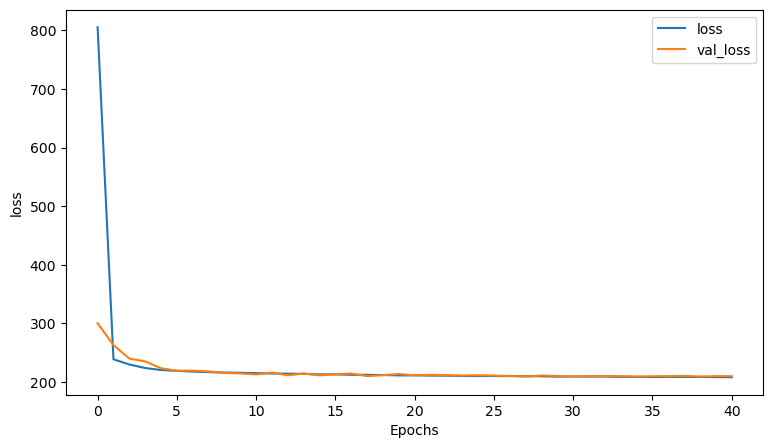

In [86]:
plot_history(history,'loss')

## Leading Questions

> **Defining the problem statements and where can this and modifications of this be used?**

The modifications of this can be used for estimating the delivery times.


----

> **List 3 functions the pandas datetime provides with one line explanation.**

1. today(): 
We can create a date object containing the current date by using the class method named today().

2. timestamp(): 
A Unix timestamp is the number of seconds between a particular date and January 1, 1970 at UTC. You can convert a timestamp to date using
the fromtimestamp() method.

3. isoweekday(): 
Returns the day of the week as integer where Monday is 1 and Sunday is 7

----

> **Short note on datetime, timedelta, time span (period)**

The datetime module supplies classes for manipulating dates and times.It provides a variety of classes for representing and manipulating
dates and times, as well as for formatting and parsing dates and times in a variety of formats.
A timedelta object represents the difference between two dates or times.
Timespans allow you to check if a timestamp falls within a specified list of boundaries. For example, you might want to program your phone
system to only accept calls Mon-Fri from 9 a.m. to 5 p.m. except on holidays like Christmas.
Timespans are specified in the form of times|daysofweek|days|months. If your timespan starts with !, it’ll only match if the timestamps falls
outside the given range.

---

> **Why do we need to check for outliers in our data?**

The outers can lead to wrong and errogenous predictions .They tend to generate larger values during the training and model is not able to find
optimal parameters. Hence they've to be treated before training.

----

> **Name 3 outlier removal methods?**

IQR method, zscore method and distance from mean method, LOF, Isolation Forest

---

> **What classical machine learning methods can we use other than random forest for regression?**

we can use linear regression,polynomial regression,decision tree regressor,GBDT regressor(Boosting regressors)

----

> **Why is scaling required for neural networks?**

if data is not standardized, then suppose:
- if one feature has a range from 1 to 1000, and the other has a range from 0 to 1
- then the weights and assosicated to these features will vary in value alot

    - With w1 being a very high value as compared to

Thus the plot for Loss function ( ) against the weights for n samples:
- Becomes a squashed, very unsymmetric and closed

Why there is an issue with a squashed and closed Loss function plot ? Ans: A very small Learning Rate will be required for gradient Descent to
reach the global minima
- thus increasing the number of steps and time

---

> **Briefly explain your choice of optimizer.**

Adams reduces the oscillations for reaching the global minima while still keeping the training epochs low .hence it has been chosen

---

> **Which activation function did you use and why?**

since the target variable has no linear relation with the data. We need to create a complex features inorder to estimate the target.In neural
network, Relu is most optimal activation function for creating the complex features and also it solves the vanishing gradient problem

---

> **Why does a neural network perform well on a large dataset?**

A large dataset enables neural networks to generalize better, learn complex patterns, optimize effectively, utilize more complex models, and benefit from enhanced regularization techniques

----